In [1]:
#import warnings
#warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

import logging
tf.get_logger().setLevel(logging.ERROR)

from collections import Counter
from random import choices
from datetime import datetime

from sklearn.preprocessing import StandardScaler

from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras.models import load_model

from Helpers import PrioritizedExperienceReplay
from Helpers_Hydro import Helpers

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
# get data
df = pd.read_csv('gold.csv')
df = df[::-1].reset_index().drop(columns='index')
# get returns
df2 = df.iloc[:,1:].pct_change()[1:]
# define standard scalers
scaler = StandardScaler()
scaler2 = StandardScaler(with_mean=False)
# normalize returns
df3 = scaler.fit_transform(df2.values.reshape(-1, 4))
# create dataframes for all
data = pd.DataFrame({
    'date': df['Date'][1:],    
    'price': df['Price'][1:],
    'open': df2['Open'],
    'low': df2['Low'],
    'high': df2['High'],
    'close': df2['Price'],
    'open_std': df3[:,:1].squeeze(),
    'low_std': df3[:,1:2].squeeze(),
    'high_std': df3[:,2:3].squeeze(),
    'close_std': df3[:,3:4].squeeze()
    })
# find and sort out outliers from normalized data
out_data = {}
sorted_ind = []
for name in data.columns.tolist()[-4:]:
    std = np.std(data[name].values)
    mu = np.mean(data[name].values)
    out_data[name] = [[], [], [], (std, mu)]
    for ind, val in enumerate(data[name].values):
        if val > mu + (3 * std) or val < mu - (3 * std):
            out_data[name][0].append(ind)
            out_data[name][1].append(val)
            sorted_ind.append(ind)
        else:
            out_data[name][2].append(val)
# Moving averages
ma_sizes = (20, 50, 200)
ma = {i: [] for i in ma_sizes}
for size in ma_sizes:
    for i in range(len(data)):
        if i <= size:
            ma[size].append(np.average(data['price']))
        else:
            value = sum(data['price'].values[i - size: i]) / size
            ma[size].append(value)   
# Exponential moving average
smoother = 2
em_sizes = (12, 20, 26)
em = {i: [] for i in em_sizes}
for size in em_sizes:
    em_t = sum(data['price'][:size]) / size
    for i in range(len(data)):
        if i <= size:
            em[size].append(0)
        else:
            em_t = (data['price'][i] * (smoother / (1 + size)) + (em_t * (1 - (smoother / (1 + size)))))
            em[size].append(em_t)
# MACD
macd1 = [i - j for i, j in zip(em[12], em[26])]
macd2 = []
macd3 = []
em_t = sum(macd1[:9]) / 9
for i in range(len(macd1)):
    if i <= 9:
        macd2.append(0)
    else:
        em_t = (macd1[i] * (smoother / (1 + size)) + (em_t * (1 - (smoother / (1 + size)))))
        macd2.append(em_t)
macd3 = [i - j for i, j in zip(macd1, macd2)]
# Normalize Technical indicators MA, EM and MACD
tech_norm = scaler.fit_transform(np.array([ma[20], ma[50], ma[200], em[20], macd1, macd2, macd3])).T
tech = pd.DataFrame({
    'ma20': tech_norm[:,:1].squeeze(),
    'ma50': tech_norm[:,1:2].squeeze(),
    'ma200': tech_norm[:,2:3].squeeze(),
    'em20': tech_norm[:,3:4].squeeze(),
    'macd1': tech_norm[:,4:5].squeeze(),
    'macd2': tech_norm[:,5:6].squeeze(),
    'macd3': tech_norm[:,6:7].squeeze()})
# Add ma to data
data[['ma20', 'ma50', 'ma200', 'em20', 'macd1', ',macd2', 'macd3']] = tech
data = data[200: -2]
#data = data.iloc[200:].drop(data.index[list(set(sorted_ind))])
data.reset_index(drop=True, inplace=True)      
# Split into train and test where test period is 365 days
train = data[:len(data) - 365]
test = data[len(data) - 365:]
test.reset_index(drop=True, inplace=True)
X_train = train[['open_std', 'low_std', 'high_std', 'close_std', 'ma20', 'ma50', 'ma200']].values
X_test = test[['open_std', 'low_std', 'high_std', 'close_std', 'ma20', 'ma50', 'ma200']].values
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)                         

X_train shape: (9203, 7)
X_test shape: (365, 7)


## Progress made:

#### X3
* moving averages (20, 50, 200)
* exponential moving average (20)
* MACD (1, 2, 3)

Total of 7 new features. Lets put them right next to the X1, all else alike. Concerning RSI we can come back for that if this turns out to be successful.

In [15]:
class TDQN:
    '''Implements a TDQN-learning trader agent.'''
    
    def __init__(self,
                 episodes=10,
                 steps=200,
                 seq_len=12,
                 batchsize=12,
                 alpha=0.001,
                 decay_rate=0.9995,
                 gamma=0.99,
                 hidden=100,
                 init_cash=5,
                 print_rate=1,
                 num_a=2,
                 mem_siz=100000,
                 filename='TDQN',
                 run=1,
                 save=False,
                 load=False,
                 get_output=True,
                 w_updates=500,
                 inf=True,
                 min_mem=0.01,
                 log_freq=50,
                 clip=1.
                 
                 ):
        
        self.episodes = episodes
        self.steps = steps
        self.seq_len = seq_len
        self.batchsize = batchsize
        self.alpha = alpha
        self.decay_rate = decay_rate
        self.gamma = gamma
        self.hidden = hidden
        self.print_rate = print_rate
        self.init_cash = init_cash
        self.num_a = num_a
        assert self.num_a % 2 == 0, 'Please enter an even action space.'
        self.filename = filename
        self.run = str(run)
        self.save = save
        self.load = load
        self.get_output = get_output
        self.w_updates = w_updates
        self.inf = inf
        self.min_mem = min_mem
        self.log_freq = log_freq
        self.clip = clip
        
        self.get_rewards = []
        self.test1 = []
        self.test11 = []
        self.test22 = []
        self.test222 = []
        self.test2222 = []
        self.test321 = []
        self.test123 = []
        self.test999 = 0
        
        self.test = None
        self.cash = None
        self.stock_v = None
        self.stock_n = None
        
        self.tmp_x2a = np.linspace(-10000, 10000, 100).reshape(50, 2)
        self.env_start = None
        self.env_count = 1
        self.s_shape = X_train.shape[-1]
        self.memory_size = mem_siz
        #self.memory_size = int((self.episodes * self.steps) // 2)
        self.memory = PrioritizedExperienceReplay(self.memory_size, self.batchsize)
        self.helpers = Helpers(self.batchsize, self.num_a, self.seq_len)
        
    def reset_env(self):
        '''Resets the environment.'''
        # reset the portfolio
        self.cash = self.init_cash
        self.stock_v = 0.
        self.stock_n = 0.
        self.env_count = 0
        # get x2
        x2a, x2b = self.get_x2()
        # test mode
        if self.test:
            self.env_start = 0
            s2 = X_test[self.env_start].reshape(1, self.s_shape)
            return [s2, x2a, x2b]
        # Train mode
        self.env_start = np.random.randint(0, len(X_train) - (self.steps + 1))
        s2 = X_train[self.env_start].reshape(1, self.s_shape)
        return [s2, x2a, x2b]
    
    def step_1(self, shift=False):
        '''Provides the current price, next step and terminal.'''
        t = False
        self.env_count += 1
        ind = self.env_start + self.env_count
        # test mode
        if self.test:
            s2 = X_test[ind].reshape(1, self.s_shape)
            p_t = test['price'][ind]
            p_std_t = test['close_std'][ind]
            p_std_t1 = test['close'][ind + 1]
            return s2, t, p_t, p_std_t, p_std_t1
        
        #### DATA AUGMENTATION ##########3
        s2 = X_train[ind]
        # add random noise
        s2 = s2 + np.random.uniform(-.2, .2)
        # randomize the order of features
        if np.random.random() < 0.5:
            np.random.shuffle(s2)
        # replace with a full random
        if np.random.random() < 0.01:
            s2 = np.random.randn(self.s_shape)
        # shift whatever we have with episodic value
        if shift:
            s2 = s2 + shift
        s2 = s2.reshape(1, self.s_shape)
        
        p_t = train['price'][ind]
        p_std_t = train['close_std'][ind]
        if ind == (self.env_start + self.steps - 2):
            t = True
            return s2, t, p_t, p_std_t
        return s2, t, p_t, p_std_t
    
    def step_2(self, a, p_t):
        '''Computes the trade and updates the portfolio.'''
        C = 0.02 # trading costs
        portfolio_value = self.cash + self.stock_v
        sizer, position = self.helpers.position_sizer(a) 
        if position: # if long
            Q = np.floor((self.cash * sizer) / (p_t * (1 + C))) # measure up the long position
        else: # if short
            Q = -np.floor(self.stock_n * sizer)
        cash = abs(self.cash - (Q * p_t) - (C * abs(Q))) # change in cash value
        stock_v = (self.stock_n + Q) * p_t # change in stock value
        stock_n = self.stock_n + Q # change in number of stock
        r = ((cash + stock_v) - portfolio_value) / portfolio_value # portfolio return as reward
            
        self.cash = cash
        self.stock_v = stock_v
        self.stock_n = stock_n
        x2a, x2b = self.get_x2()
        return r, x2a, x2b
    
    def per_targets(self, model, model_2, S, A, R, S2, T, is_w):
        '''Computes the per target term.'''
        self.test2345 = (S, S2, A, R)
        q_nexts = model.predict(S2, batch_size=self.batchsize).squeeze()
        q_maxs = [np.argmax(q_nexts[i]) for i in range(self.batchsize)]
        t_nexts = model_2.predict(S2, batch_size=self.batchsize).squeeze()
        deltas = []
        for i in range(self.batchsize):
            r = R[i]
            t = T[i]
            if t:
                deltas.append(r)
            else:
                deltas.append(r + (self.gamma * t_nexts[i][q_maxs[i]]))
        targets = tmp = model.predict(S, batch_size=self.batchsize).squeeze()
        deltas2 = []
        for i in range(self.batchsize):
            targets[i, A[i]] = deltas[i]
            d = deltas[i] - tmp[i][A[i]]
            deltas2.append(0.5 * d ** 2 if abs(d) < 1.0 else abs(d) - 0.5)
        ###########test
        self.test5 = (q_nexts, t_nexts, tmp, targets)
        return targets, deltas2
    
    def policy(self, model, s, epsilon):
        '''Generates an action given a state.'''
        if np.random.random() < epsilon:
            action_preference = np.random.randint(0, self.num_a)
        else:
            q = model.predict(s, batch_size=self.batchsize).squeeze()
            max_a = []
            for i, j in enumerate(q):
                if j == np.amax(q):
                    max_a.append(i)
            ### Return random if list is nan
            if not max_a:
                action_preference = np.random.randint(0, self.num_a)
                return action_preference
            action_preference = np.random.choice(max_a)
        return action_preference
    
    def get_x2(self):
        'generates the x2 state online.'
        tmp = np.concatenate((self.tmp_x2a, np.array([[self.cash, self.stock_v]])), axis=0)
        x2a = scaler.fit_transform(tmp)[-1]
        x2b = np.zeros((60))
        x2b[int(self.stock_n)] = 1.
        return x2a.reshape(1, 2), x2b.reshape(1, 60)
    
    def unpack(self, transitions):
        '''Gets a batch from memory and slices it.'''
        S = [transitions[i][0] for i in range(self.batchsize)]
        A = np.array([transitions[i][1] for i in range(self.batchsize)])
        R = np.array([transitions[i][2] for i in range(self.batchsize)])
        S2 = [transitions[i][3] for i in range(self.batchsize)]
        T = np.array([transitions[i][4] for i in range(self.batchsize)])
        # stack respective input in S and S2
        x1_s, x1_s2 = S[0][0], S2[0][0]
        x2a_s, x2a_s2 = S[0][1], S2[0][1]
        x2b_s, x2b_s2 = S[0][2], S2[0][2]
        for i, j in zip(S[1:], S2[1:]):
            #########test
            self.test4 = (S, x1_s, x1_s2, i, j)
            x1_s, x1_s2 = np.concatenate((x1_s, i[0])), np.concatenate((x1_s2, j[0]))
            x2a_s, x2a_s2 = np.concatenate((x2a_s, i[1])), np.concatenate((x2a_s2, j[1]))
            x2b_s, x2b_s2 = np.concatenate((x2b_s, i[2])), np.concatenate((x2b_s2, j[2]))
        S, S2 = [x1_s, x2a_s, x2b_s], [x1_s2, x2a_s2, x2b_s2]
        return S, A, R, S2, T
    
    def train(self):
        '''Trains selected RL agent.'''
        epsilon = 1
        if self.load:
            epsilon = 0.1
        delta = 1
        Actions = {i: 0 for i in range(self.num_a)}
        dists = {'cash': [], 'stock_v': [], 'stock_n': []}
        P_value = []
        avg_loss = []
        avg_c = []
        avg_v = []
        avg_n = []
        p_value = []
        
        # define loss and optimizer objects
        loss_object = tf.keras.losses.Huber()
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.alpha) #clipnorm=self.clip
        self.helpers.tensorboard_writer(logdir='logs/' + self.filename + str(self.run))
        
        # build model
        if self.load:
            model = load_model(
                'saved/' + self.filename + '/' + str(self.run) + '/model_' + str(episode))
            model2 = load_model(
                'saved/' + self.filename + '/' + str(self.run) + '/model2_' + str(episode))
            self.memory.sum_tree.data = np.load(
                'saved/' + self.filename + '/' + str(self.run) + '/data_' + str(episode), 
                allow_pickle=True)
            self.get_output = False
        else:
            # X1 stream
            x1_in = Input(shape=(self.s_shape,))
            x1 = Dense(250)(x1_in)
            l1 = LeakyReLU()(x1)
            bn1 = BatchNormalization()(l1)
            # X2a stream
            x2a_in = Input(shape=(2,))
            x2 = Dense(100)(x2a_in)
            l2 = LeakyReLU()(x2)
            bn2 = BatchNormalization()(l2)
            # X2b stream
            x2b_in = Input(shape=(60,))
            x3 = Dense(50)(x2b_in)
            l3 = LeakyReLU()(x3)
            bn3 = BatchNormalization()(l3)
            # Concat layers
            c = Concatenate()([bn1, bn2, bn3])
            # Layer 2
            x4 = Dense(300)(c)
            l4 = LeakyReLU()(x4)
            bn4 = BatchNormalization()(l4)
            # Output layer
            x_out = Dense(self.num_a, activation='linear')(bn4)
            layer_outputs = [x1, l1, bn1, x2, l2, bn2, x3, l3, bn3, x4, l4, bn4, x_out]
            model = Model([x1_in, x2a_in, x2b_in], x_out)
            model_2 = Model([x1_in, x2a_in, x2b_in], x_out)
            model.compile(optimizer=optimizer, loss=loss_object)
        self.testmodel = model
        self.testmodel2 = model_2
        
        # EPISODES
        for episode in range(self.episodes):
            # reset metrics
            actions = []
            temp_trans = []
            
            # data augment shift value
            shift = np.random.uniform(-0.25, 0.25)
            
            # reset environment
            s = self.reset_env()
            
            # weight update
            if episode % self.w_updates == 0:
                weights = model.get_weights()
                model_2.set_weights(weights)
            # epsilon decay
            if epsilon > 0.1:
                epsilon = epsilon * self.decay_rate**episode
            else:
                epsilon = 0.1
            # STEPS
            for step in range(2500): # breaks when terminal
                # frame skipping
                #if step % 4 == 0: 
                a = self.policy(model, s, epsilon) 
                s2_x1, t, p_t, p_std_t = self.step_1(shift) 
                r, x2a, x2b = self.step_2(a, p_t)
                s2 = [s2_x1, x2a, x2b]
                # TRAINING
                if self.memory.len_memory() > (self.min_mem * self.memory_size):
                    # get transition
                    transitions, idxs, is_w = self.memory.sample_transition()
                    # unpack transition
                    S, A, R, S2, T = self.unpack(transitions)
                    # get targets
                    targets, deltas = self.per_targets(model, model_2, S, A, R, S2, T, is_w)
                    # optimize
                    loss = model.train_on_batch(x=S, y=targets, sample_weight=is_w)
                    # collect scalars
                    avg_loss.append(loss)
                avg_c.append(self.cash)
                avg_v.append(self.stock_v)
                avg_n.append(self.stock_n)
                p_value.append(self.cash + self.stock_v)
                actions.append(a)
                if t:
                    break
                #### reward clipping #####
                if r > 0:
                    r = 1.
                elif r < 0:
                    r = -1.
                # store transition
                self.memory.store_transition(delta, (s, a, r, s2, t, p_t))
                s = s2
            ############# tensorboard 1 ##########################
            if episode % (self.episodes // self.log_freq) == 0:
                # compute gradients
                weights = model.trainable_weights
                grads = K.gradients(model.output, weights)
                f = K.function([model.input], grads)
                eval_grads = f([s])
                mean_eval_grads = np.mean([np.mean(g) for g in eval_grads])
                # write scalars to tensorboard each episode
                self.helpers.tensorboard_scalar('loss', np.mean(avg_loss), episode)
                self.helpers.tensorboard_scalar('score', np.mean(p_value), episode)
                self.helpers.tensorboard_scalar('grads', mean_eval_grads, episode)
                # write gardient histograms to tensorboard
                for w, g in zip(weights, eval_grads):
                    self.helpers.tensorboard_hist(w.name + 'grads_', g, episode)
                # write weights to tensorboard
                for layer in model.layers[1:]:
                    for i, value in enumerate(layer.get_weights()):
                        tag = layer.weights[i].name
                        self.helpers.tensorboard_hist(tag, value, episode) 
                if self.get_output:
                    # write outputs to tensorboard
                    for i, layer_output in enumerate(layer_outputs):
                        output = Model(
                            [x1_in, x2a_in, x2b_in], layer_output).predict(s, batch_size=self.batchsize)
                        self.helpers.tensorboard_hist('layer_output/' + str(i), output, episode)
                # dists
                dists['cash'].append(np.mean(avg_c))
                dists['stock_v'].append(np.mean(avg_v))
                dists['stock_n'].append(np.mean(avg_n))
                P_value.append(np.mean(p_value))
                # actions
                for key in Counter(actions).keys():
                    Actions[key] += Counter(actions)[key]
                actions, avg_loss, p_value, avg_c, avg_v, avg_n, = [], [], [], [], [], []
            # PLOT
            if (episode + 1) % (self.episodes // self.print_rate) == 0:
                print(datetime.now())
                self.helpers.plot_train(episode, dists, P_value, Actions, self.filename, self.run)
                # inference
                if self.inf:
                    self.inference(model, episode)
                if self.save:
                    dir_path = 'saved/' + self.filename + '/' + str(self.run)
                    file_path_model = '{}/model_' + str(episode) 
                    file_path_model_2 = '{}/model2_' + str(episode) 
                    file_path_data = '{}/data' + str(episode)
                    self.helpers.mkdir_p(dir_path)
                    model.save(file_path_model.format(dir_path))
                    model_2.save(file_path_model_2.format(dir_path))
                    np.save(file_path_data.format(dir_path), self.memory.sum_tree.data)
        
    def inference(self, model, episode):
        '''Tests the agent upon the full period.'''
        self.test = True
        s = self.reset_env()
        Actions = {i: 0 for i in range(self.num_a)}
        actions = []
        Score2 = []
        Score = []
        score = 0
        p_value = []
        Q_values = {i: [] for i in range(self.num_a)}
        for step in range(len(X_test) - 2):
            a = self.policy(model, s, epsilon=0)
            s2_x1, _, p_t, _, p_t1 = self.step_1()
            r, x2a, x2b = self.step_2(a, p_t)
            s2 = [s2_x1, x2a, x2b]
            p_value.append(self.cash + self.stock_v)
            score += r
            q_values = model.predict(s).squeeze()
            for ind, value in enumerate(q_values):
                Q_values[ind].append(value)
                for ind, value in enumerate(q_values):
                    Q_values[ind].append(value)
            if a == 0:
                if p_t1 > 0:
                    Score2.append(0)
                else:
                    Score2.append(2)
            elif a == 1:
                if p_t1 < 0:
                    Score2.append(1)
                else:
                    Score2.append(2)
            Score.append(score)
            actions.append(a)
            s = s2
        for key in Counter(actions).keys():
            Actions[key] += Counter(actions)[key]
        buy, opt, buy_p, opt_p = self.helpers.optimum(test, self.init_cash)
        self.helpers.plot_inference(data, p_value, Score, Score2, Q_values, 
                                    Actions, buy, opt, buy_p, opt_p, self.filename, self.run, episode)
        self.test = False
        
    def train_multiple(self):
        '''Trains multiple variations of agents.'''
        run = 1
        
        run_data = (150, 300)
        run_data_1 = ()
        
        for i in run_data:
            self.run = str(run)
            print('*'*65, '\n', 'run:', run, 'time:', datetime.now()) ####3 note i and j
            # Run variables #  
            self.hidden = i
            self.episodes = run_data_1[i]
            # Memory reset
            self.memory = PrioritizedExperienceReplay(self.memory_size, self.batchsize)
            ################
            self.train()
            K.clear_session()
            run += 1

## Notes:

* testing the new X3 features

/home/mikael/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mikael/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2020-09-22 17:20:15.623560
episode: 165


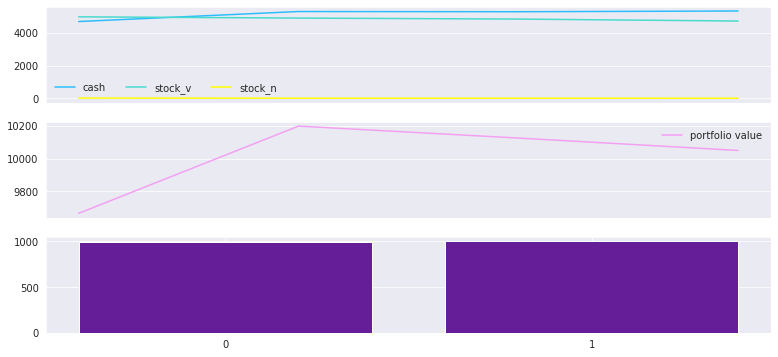

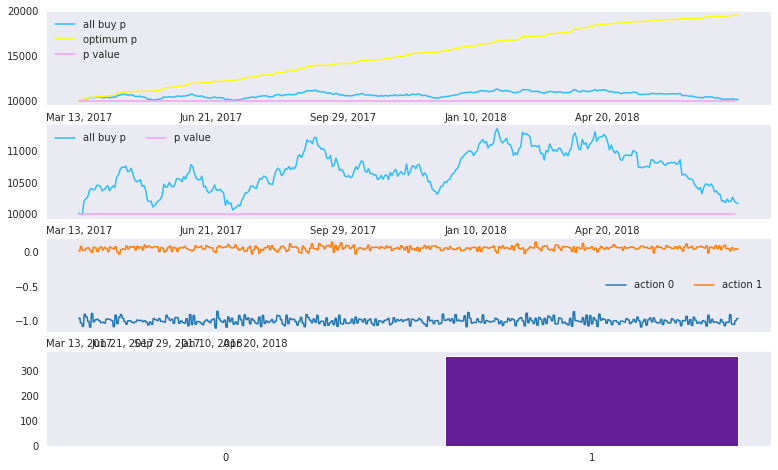

2020-09-22 17:36:49.236046
episode: 331


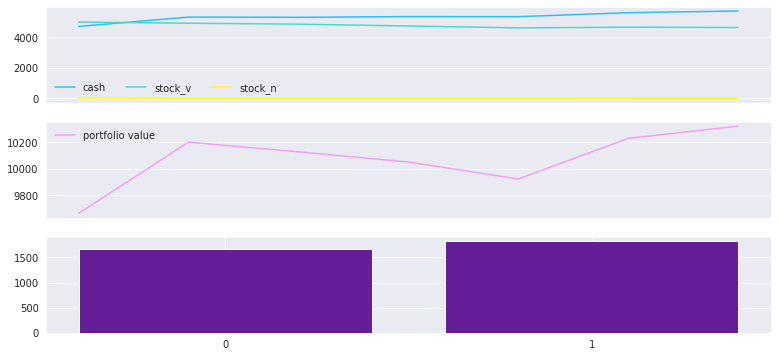

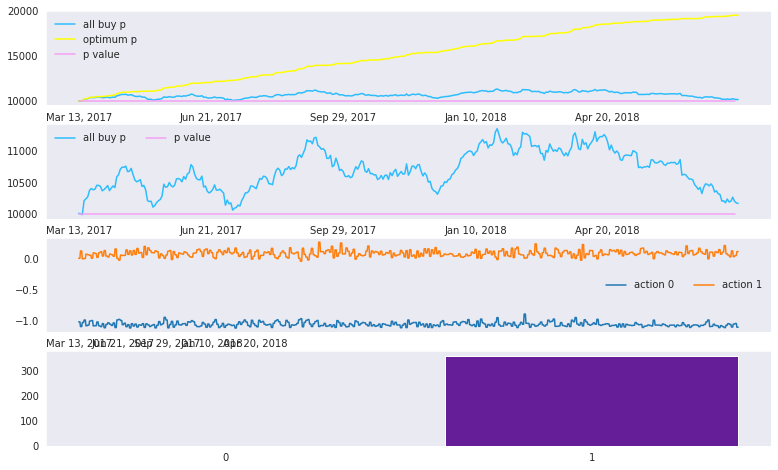

2020-09-22 17:53:51.274970
episode: 497


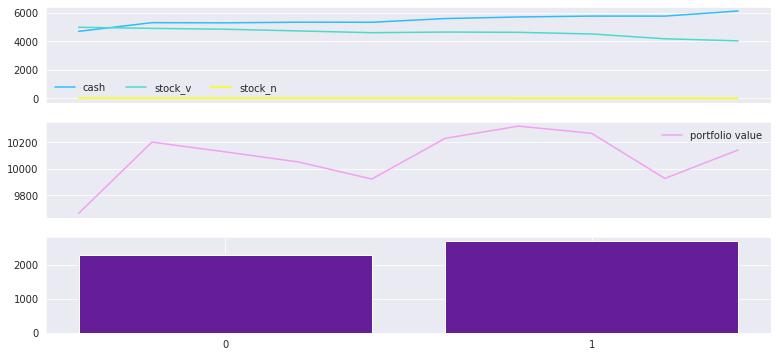

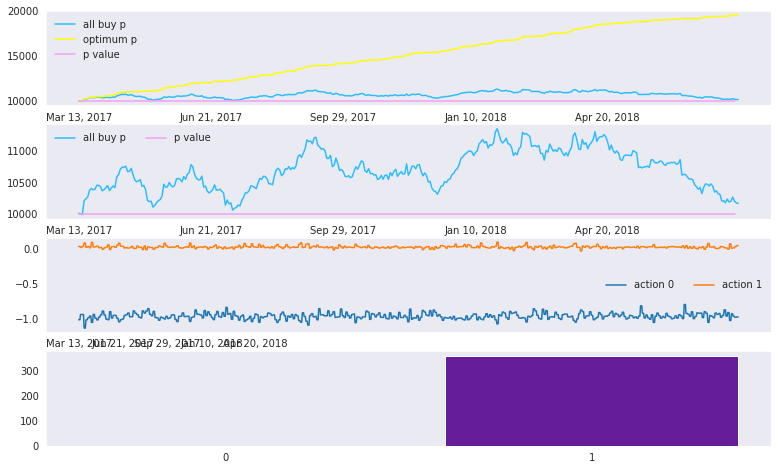

2020-09-22 18:11:37.208109
episode: 663


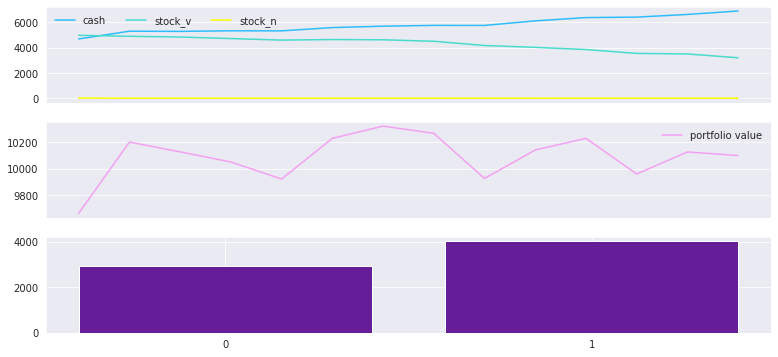

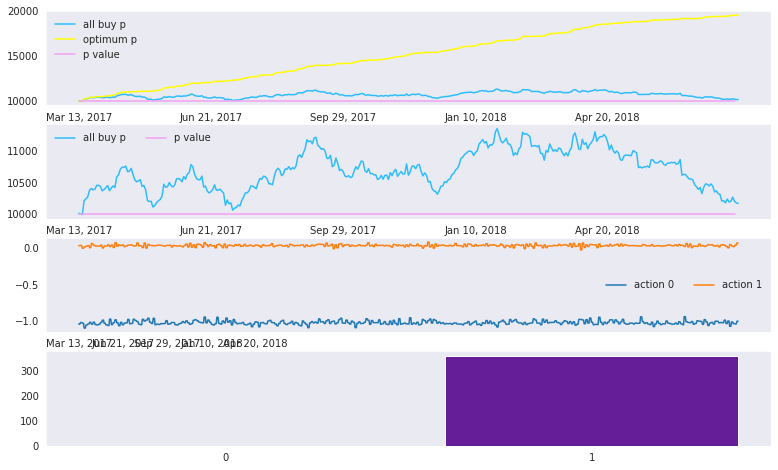

2020-09-22 18:30:01.900319
episode: 829


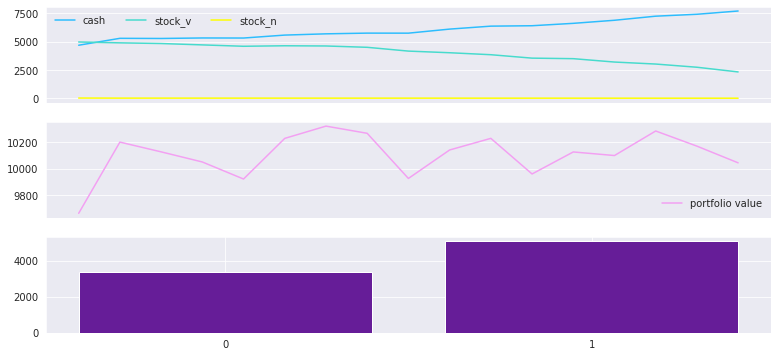

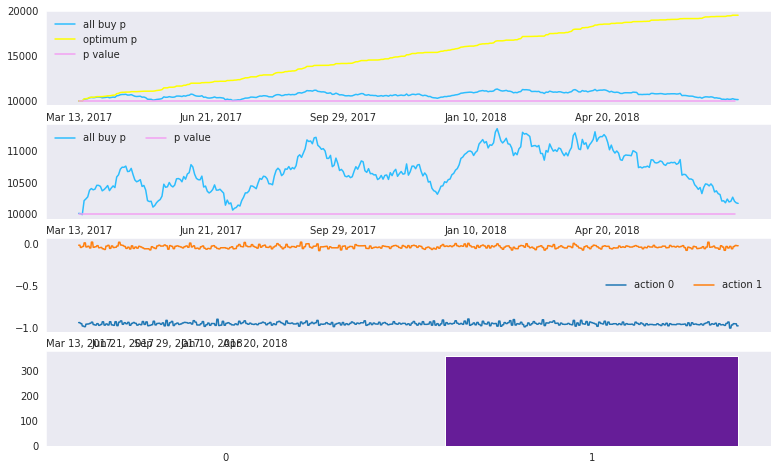

2020-09-22 18:48:43.666818
episode: 995


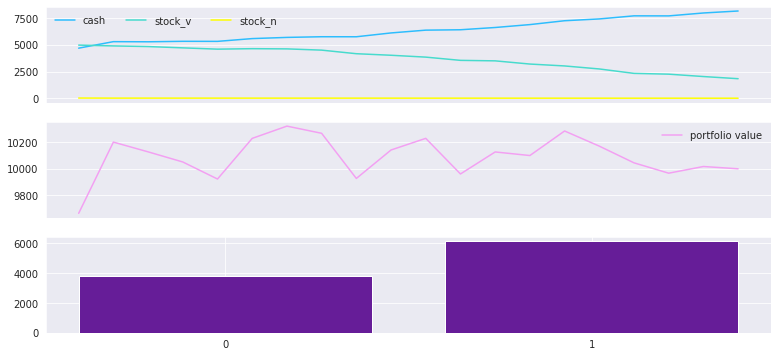

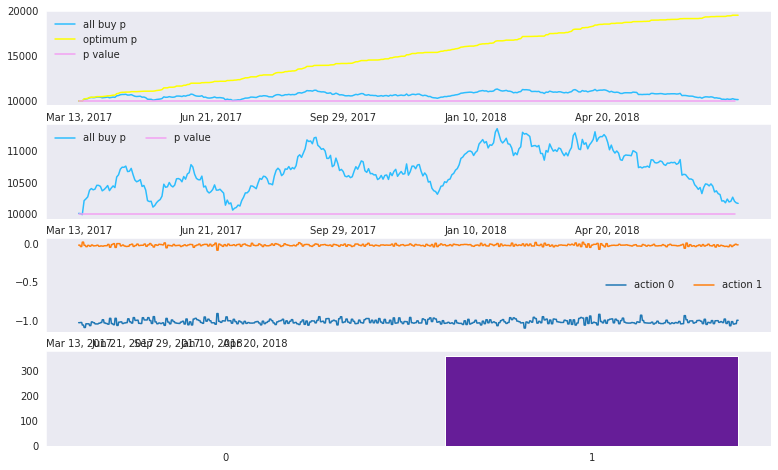

2020-09-22 19:07:46.112153
episode: 1161


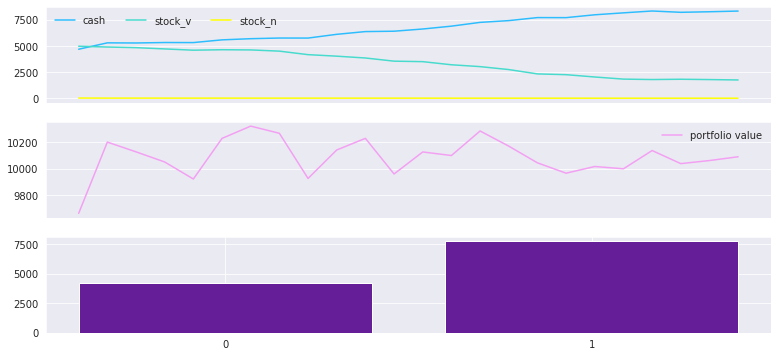

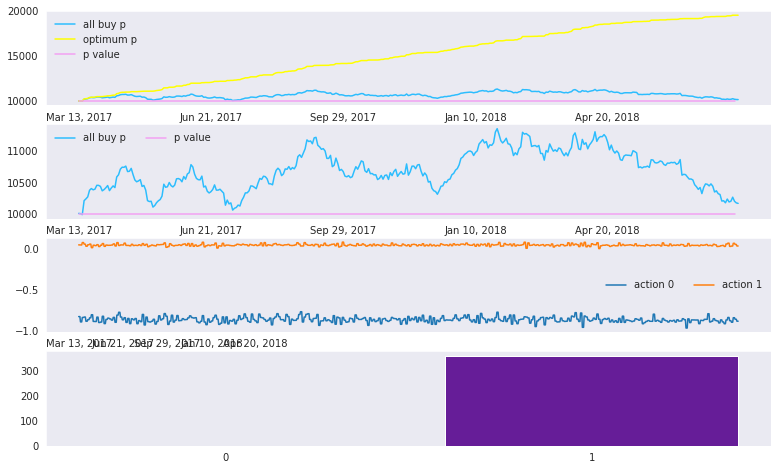

2020-09-22 19:26:52.667674
episode: 1327


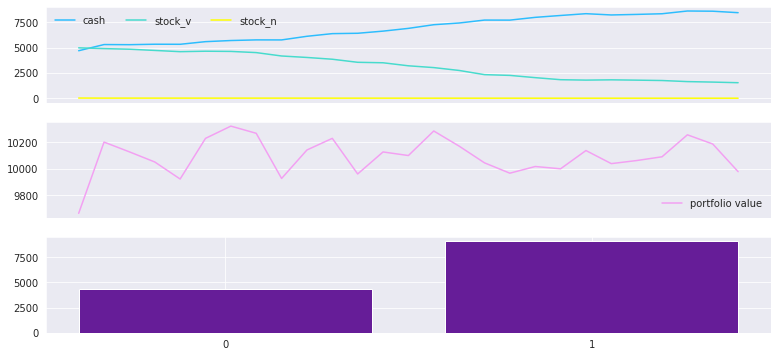

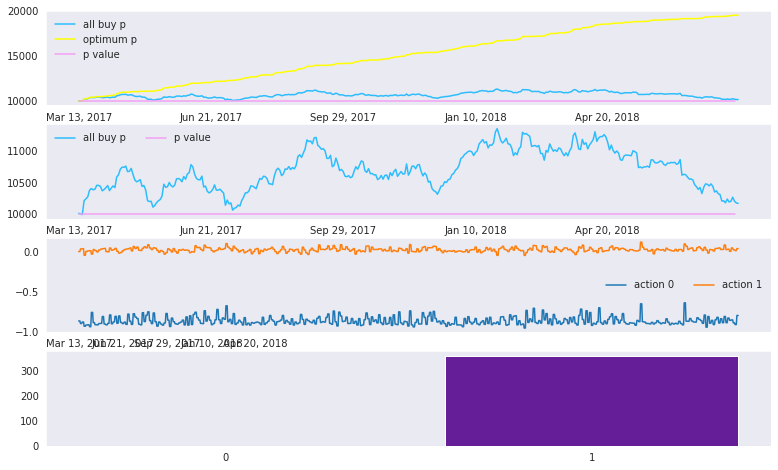

2020-09-22 19:45:42.522069
episode: 1493


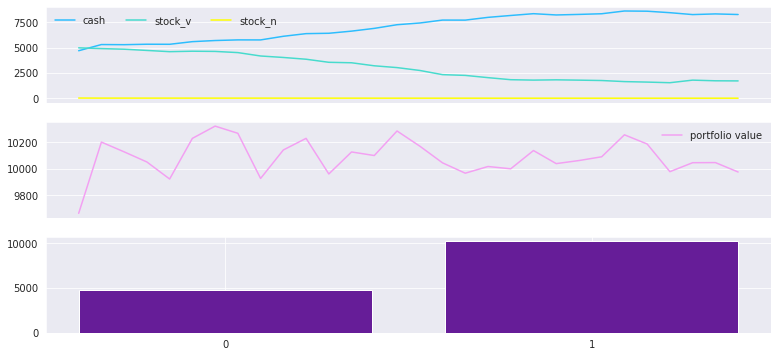

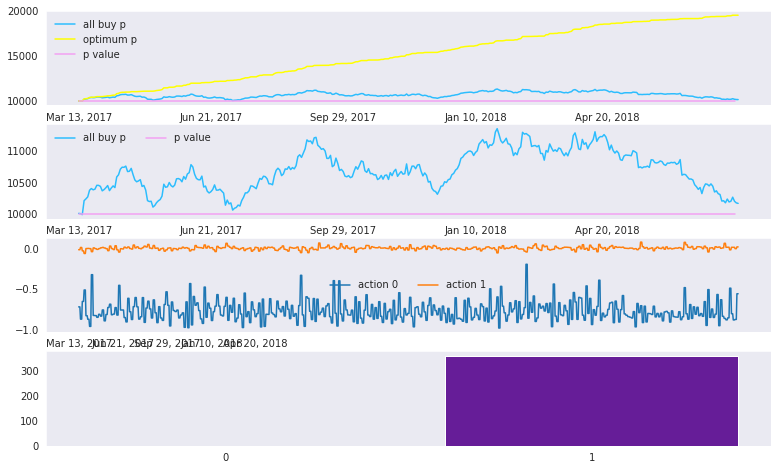

2020-09-22 20:05:03.948569
episode: 1659


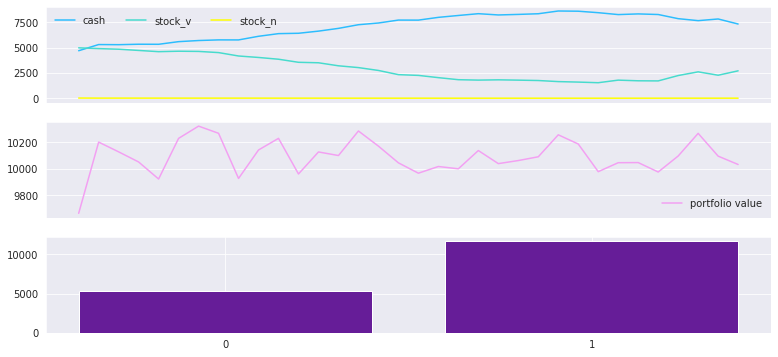

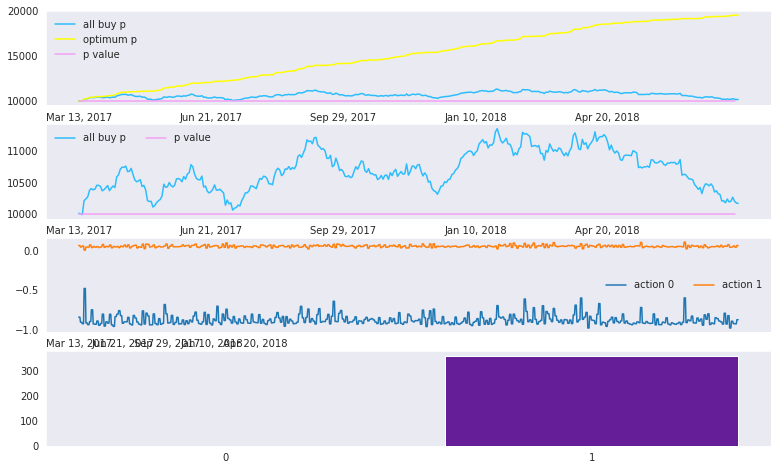

2020-09-22 20:24:34.927242
episode: 1825


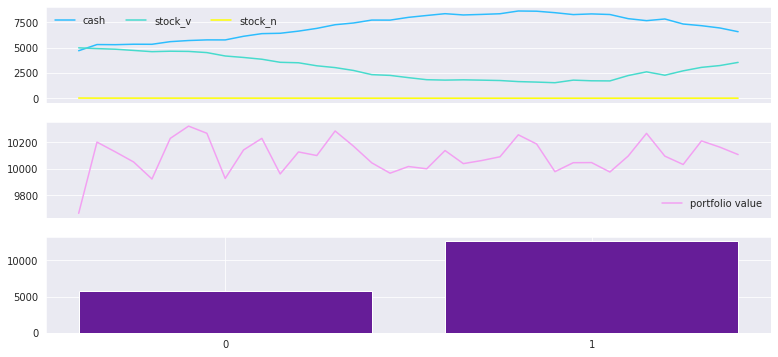

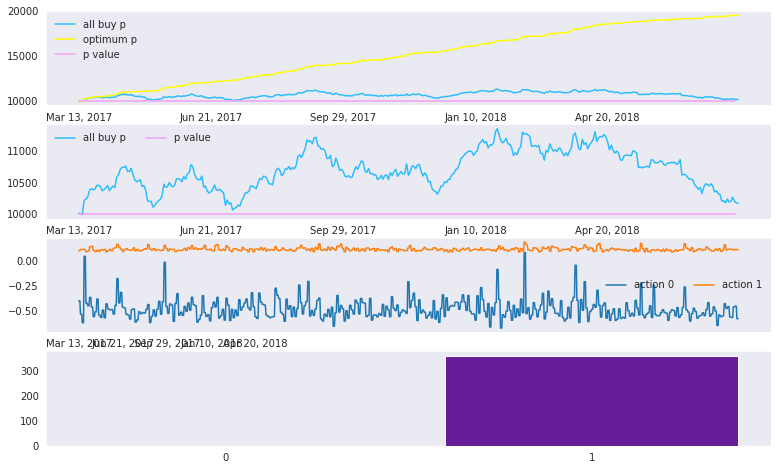

2020-09-22 20:43:53.561151
episode: 1991


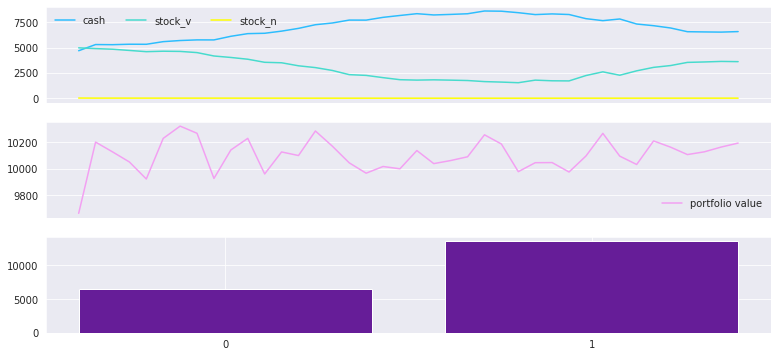

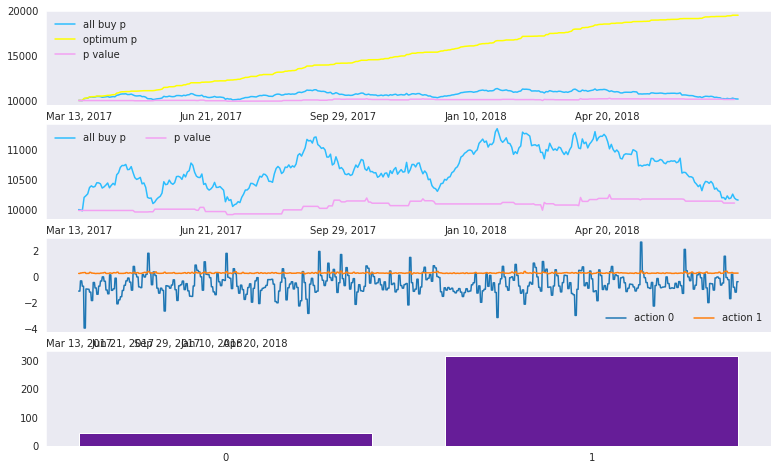

2020-09-22 21:03:50.062348
episode: 2157


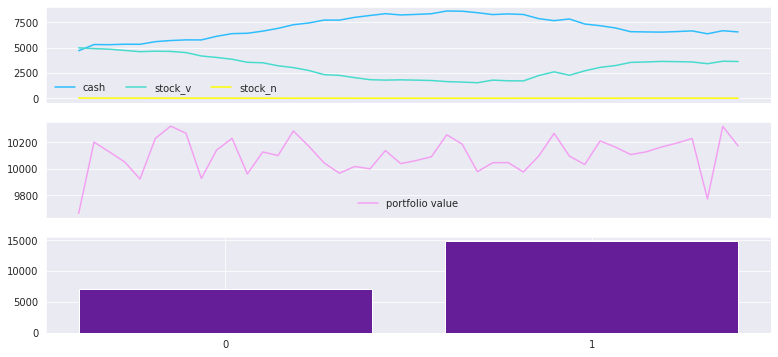

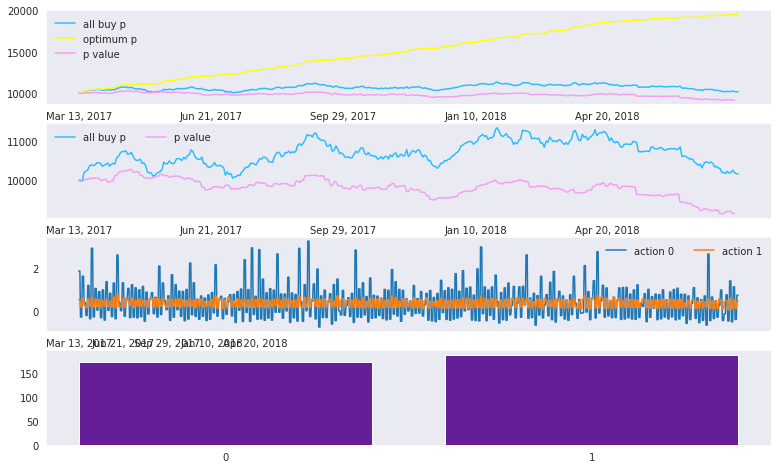

2020-09-22 21:23:39.406635
episode: 2323


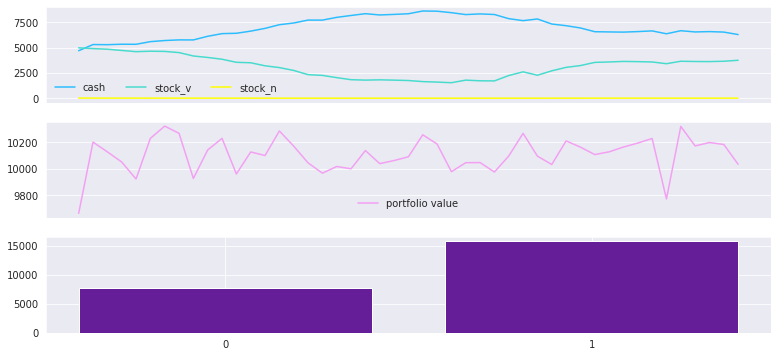

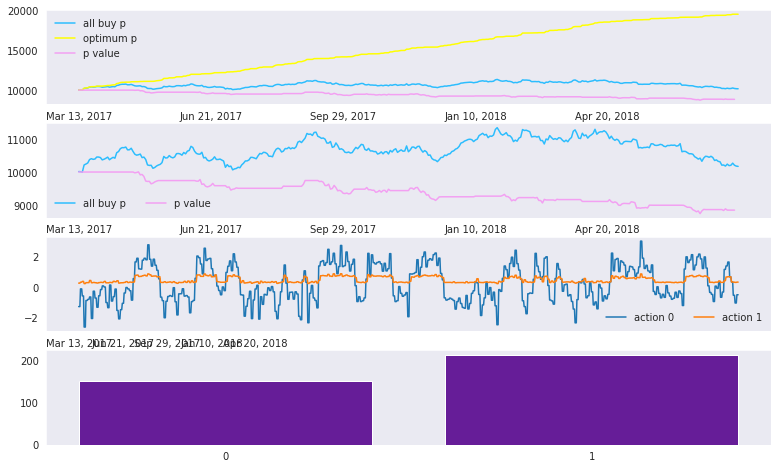

2020-09-22 21:42:35.899464
episode: 2489


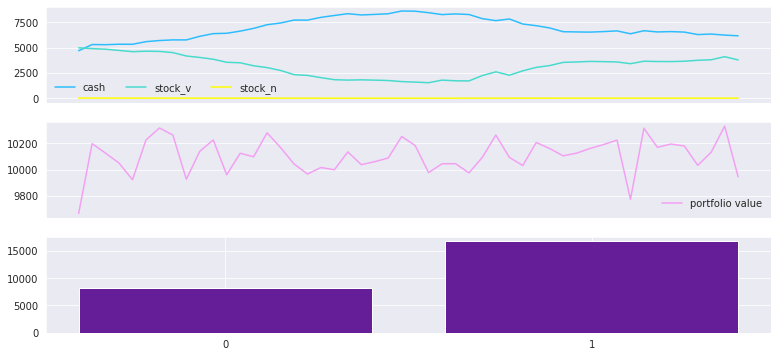

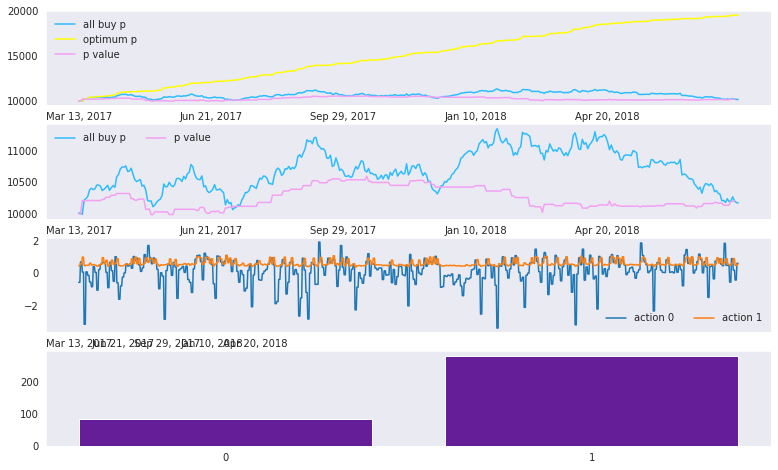

2020-09-22 22:02:20.025638
episode: 2655


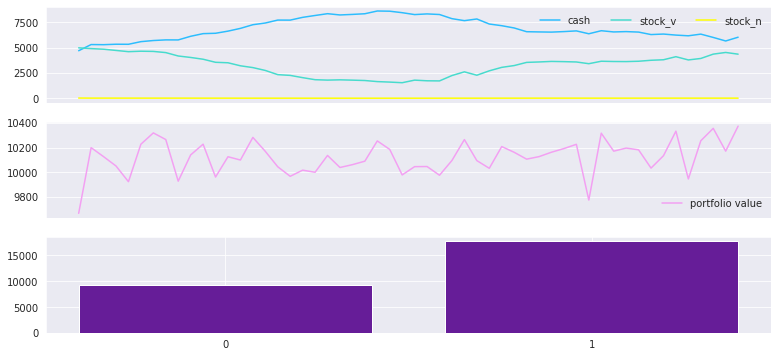

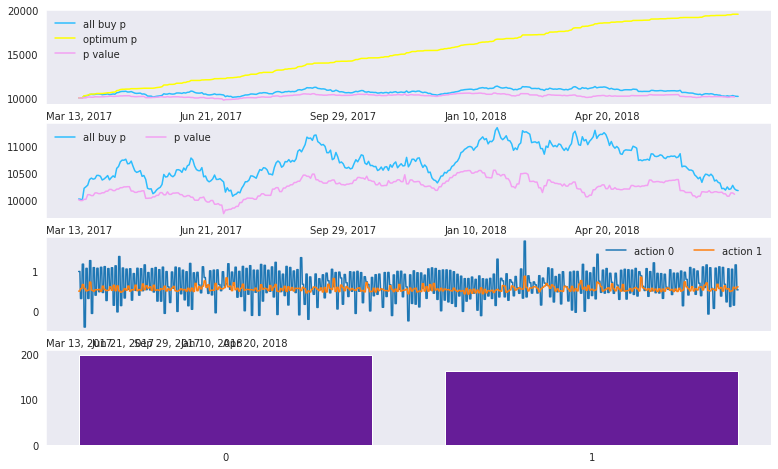

2020-09-22 22:21:22.813567
episode: 2821


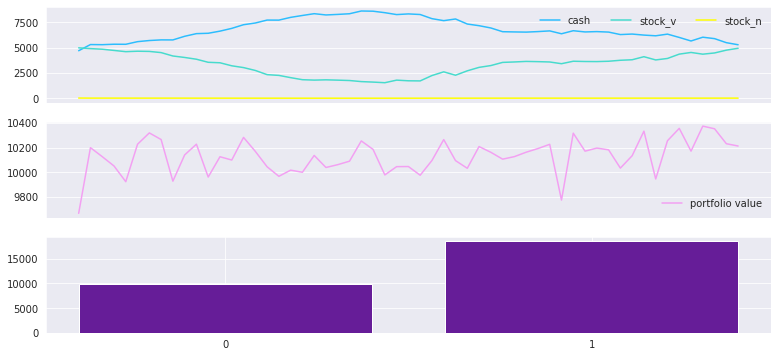

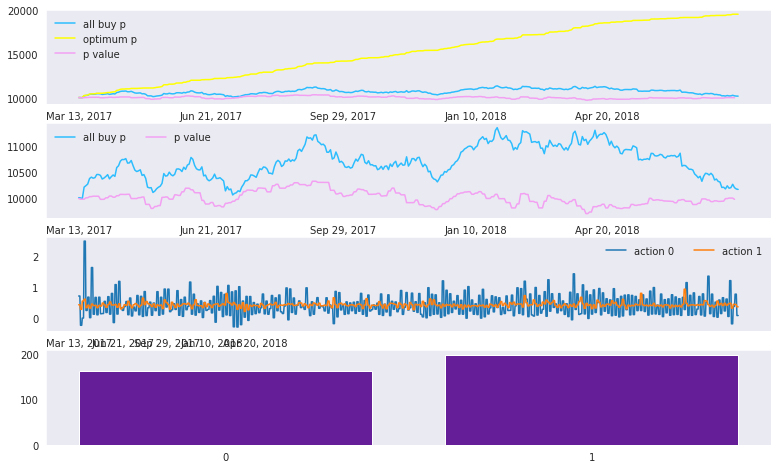

2020-09-22 22:40:47.163021
episode: 2987


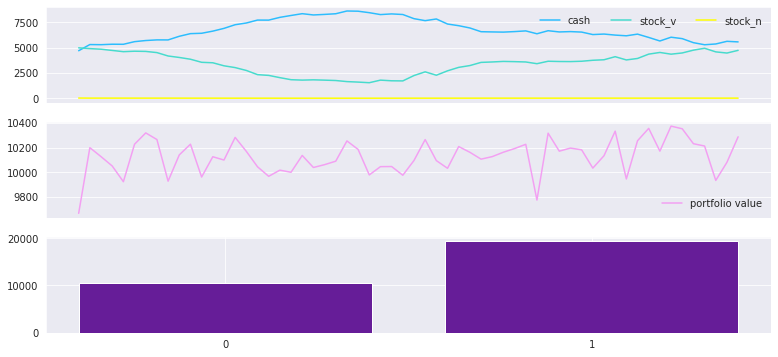

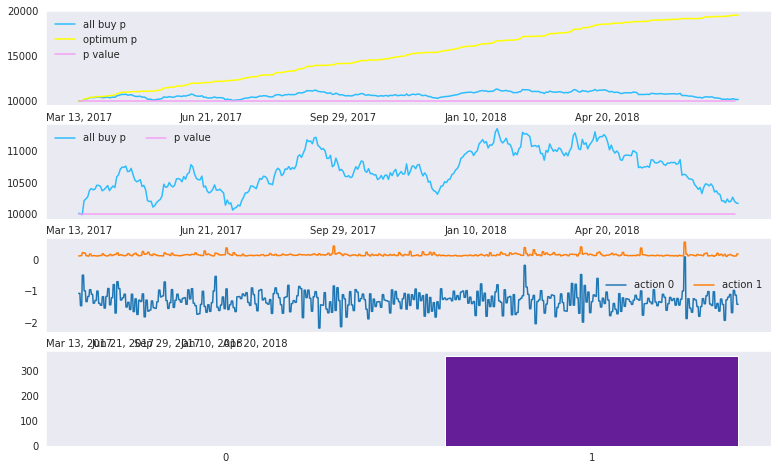

2020-09-22 23:01:18.506583
episode: 3153


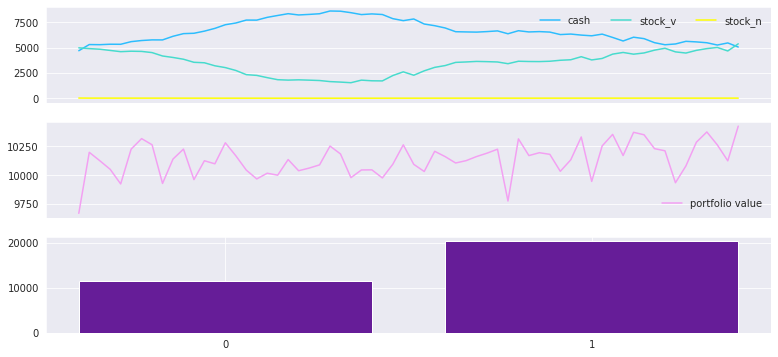

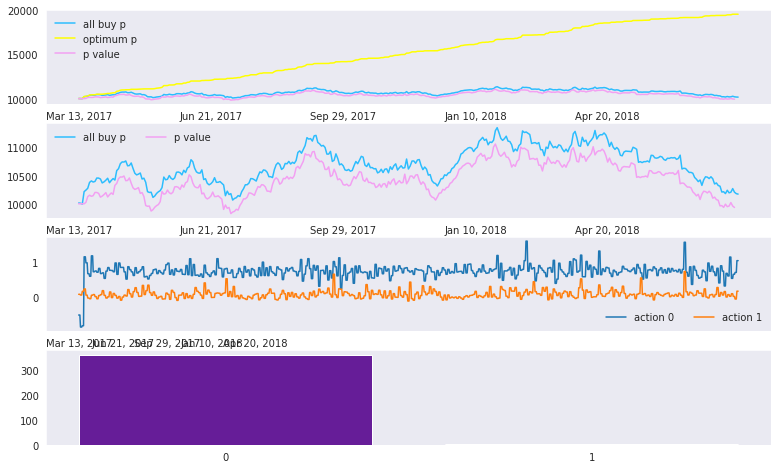

2020-09-22 23:21:21.335626
episode: 3319


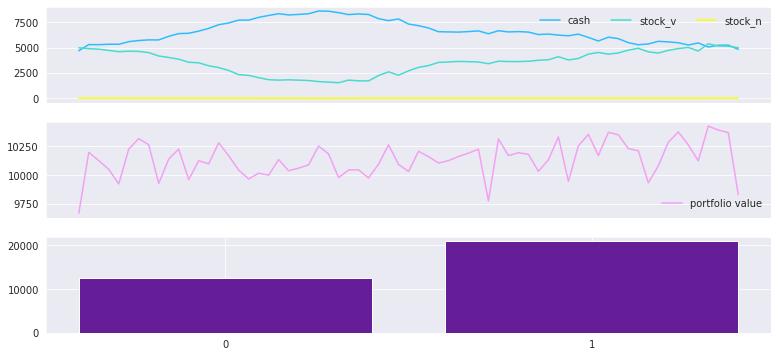

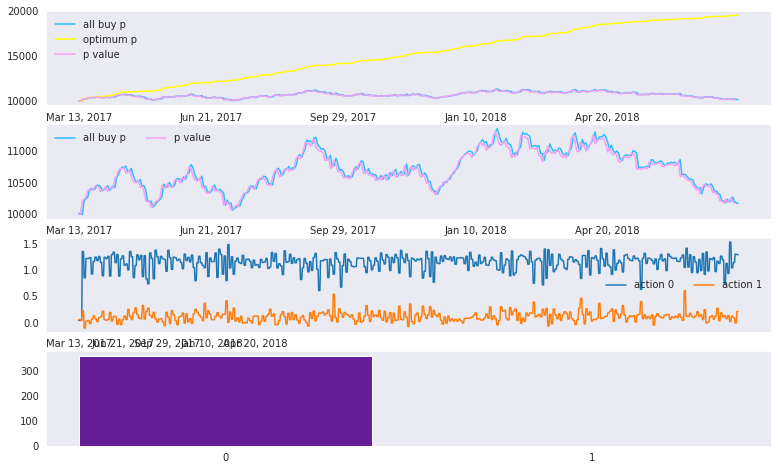

2020-09-22 23:41:23.462626
episode: 3485


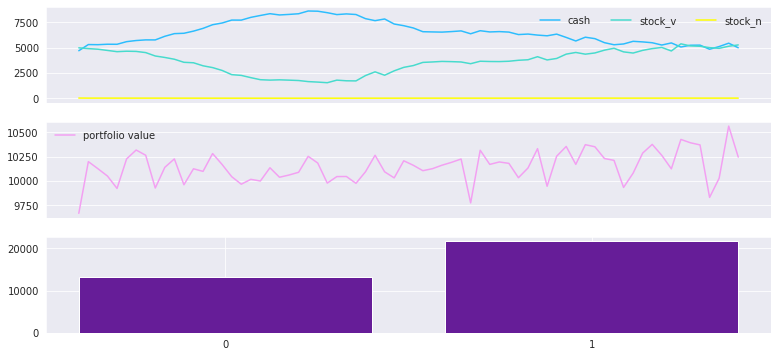

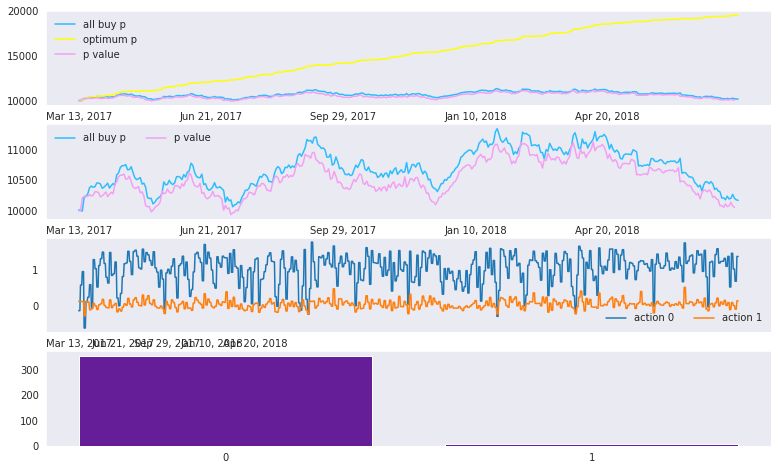

2020-09-23 00:01:47.138280
episode: 3651


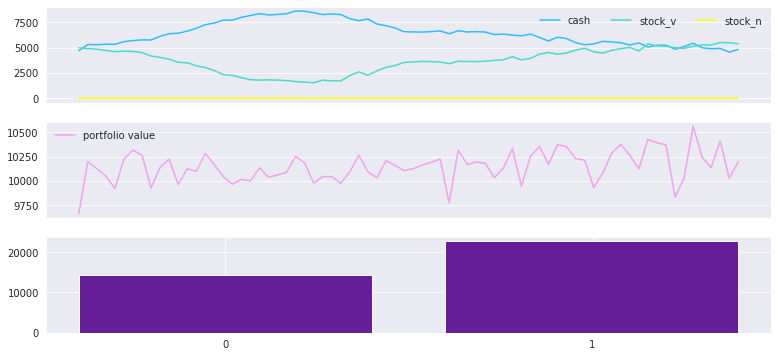

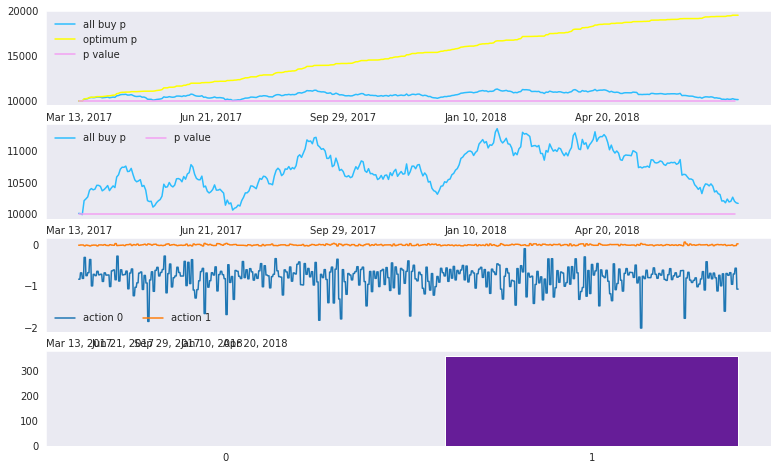

2020-09-23 00:21:54.511304
episode: 3817


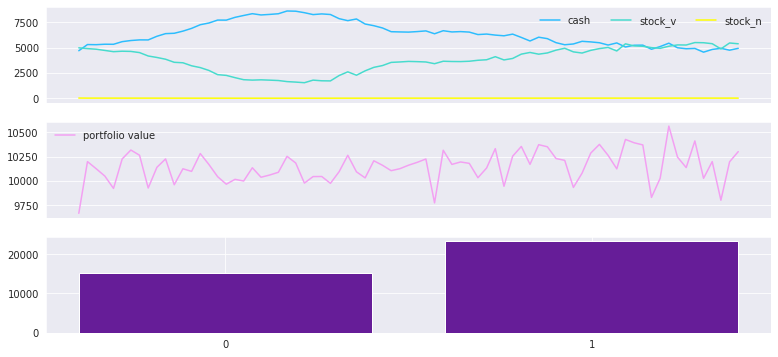

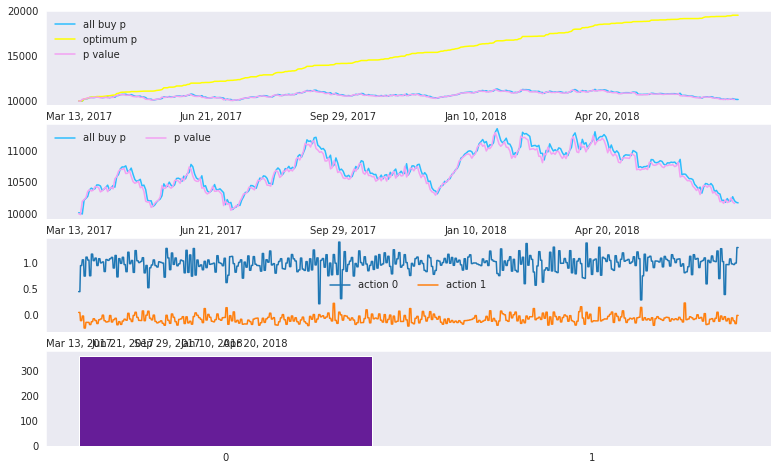

2020-09-23 00:42:00.678269
episode: 3983


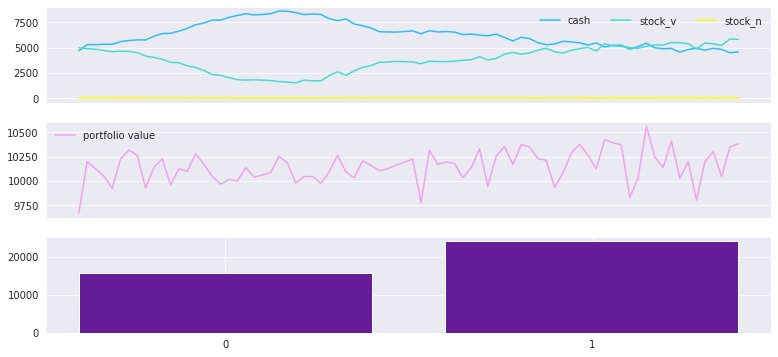

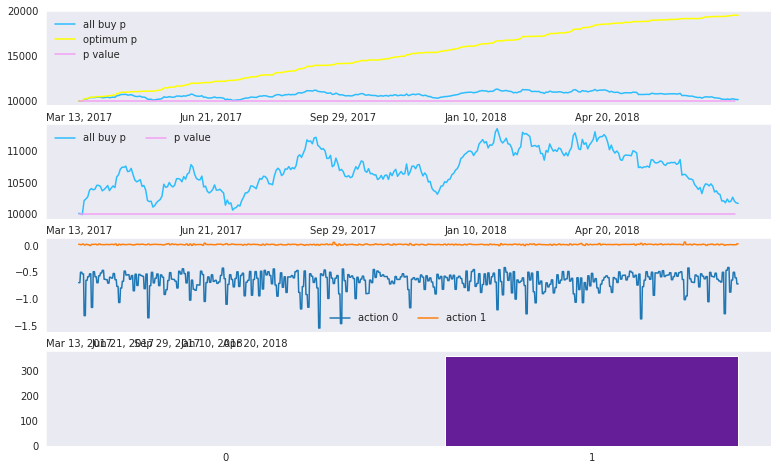

2020-09-23 01:02:09.510048
episode: 4149


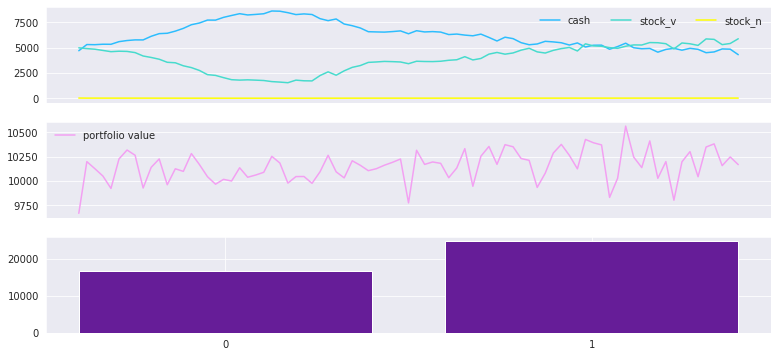

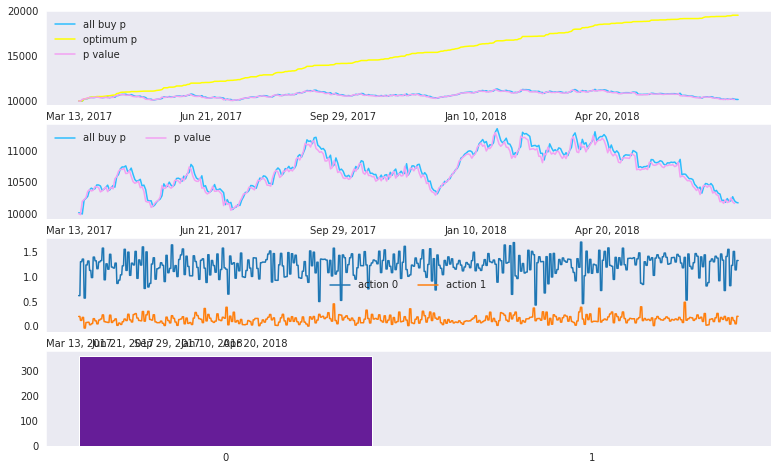

2020-09-23 01:22:40.816439
episode: 4315


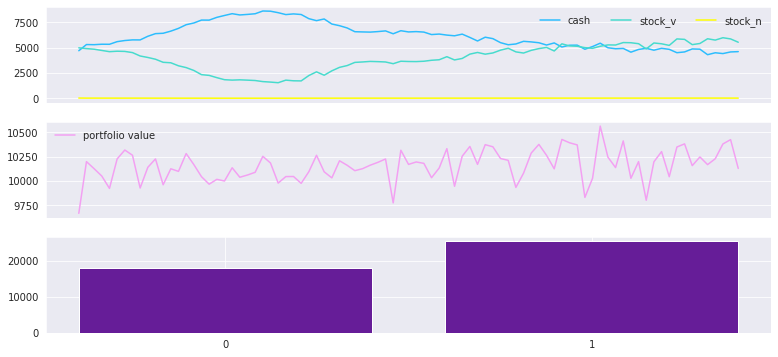

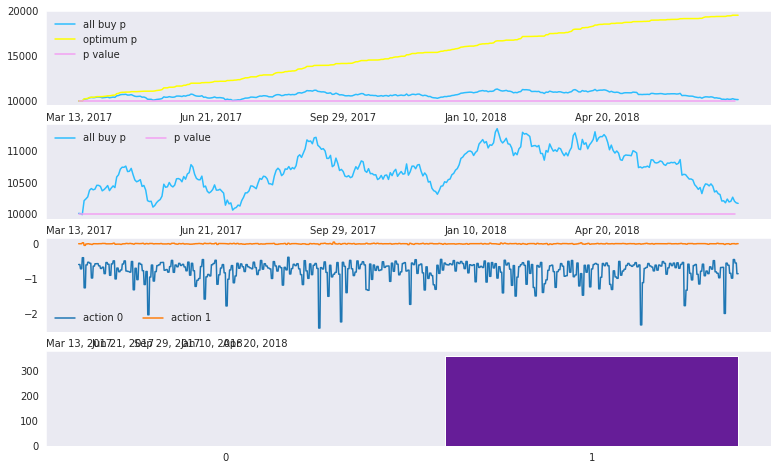

2020-09-23 01:42:56.057813
episode: 4481


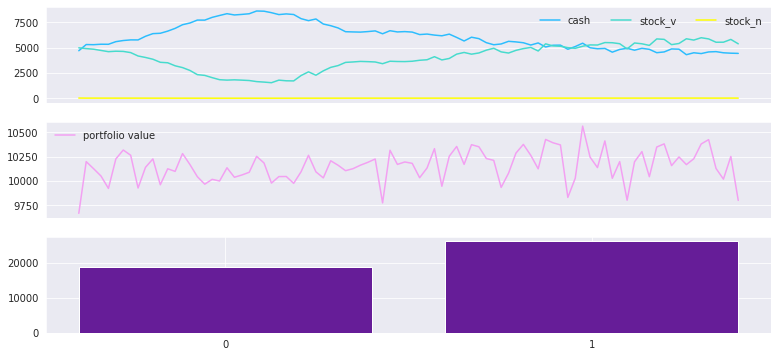

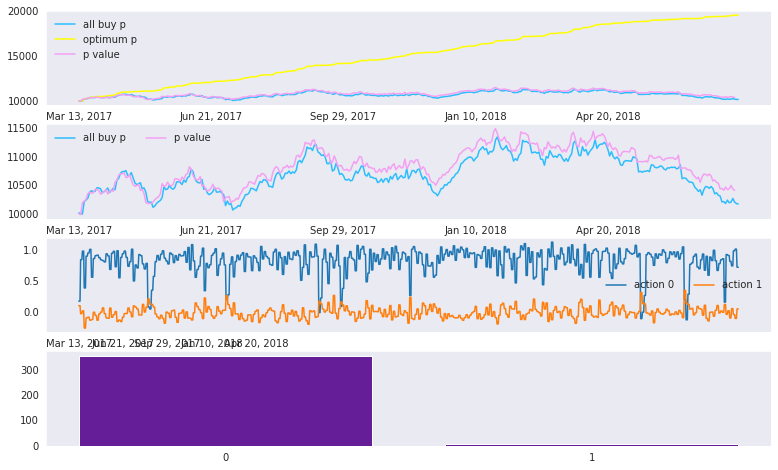

2020-09-23 02:03:09.597912
episode: 4647


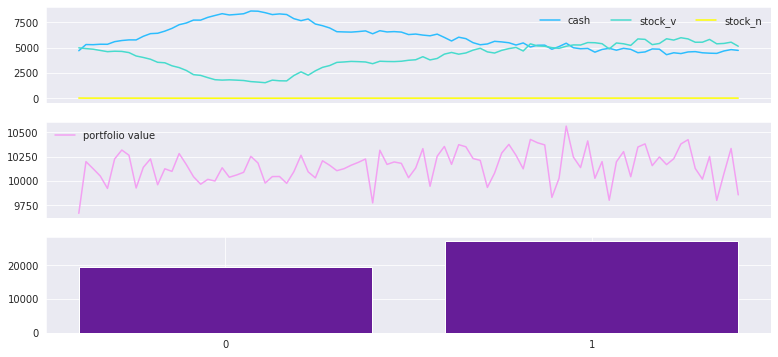

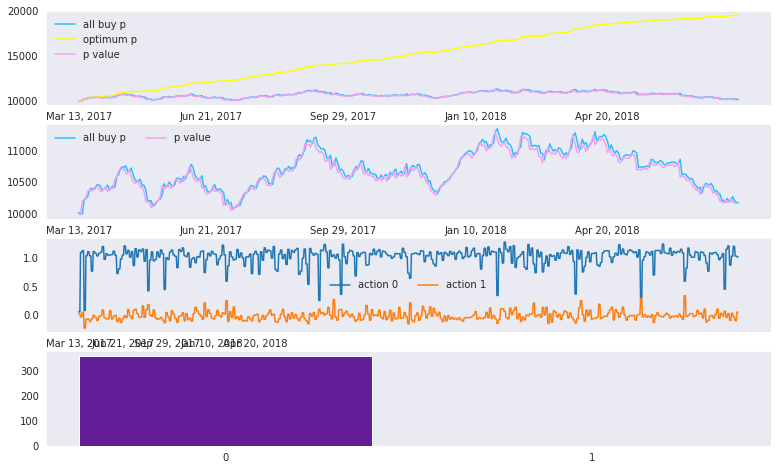

2020-09-23 02:23:50.469175
episode: 4813


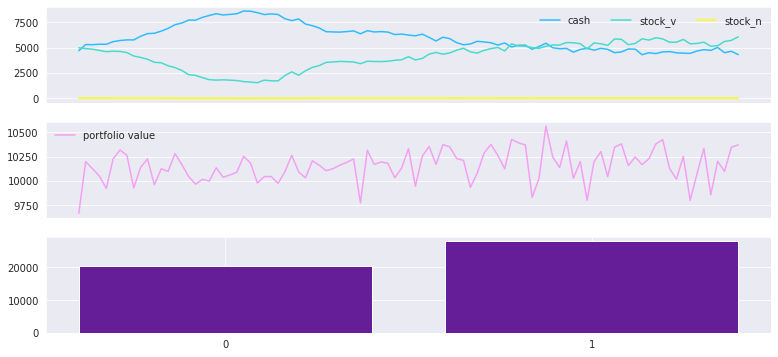

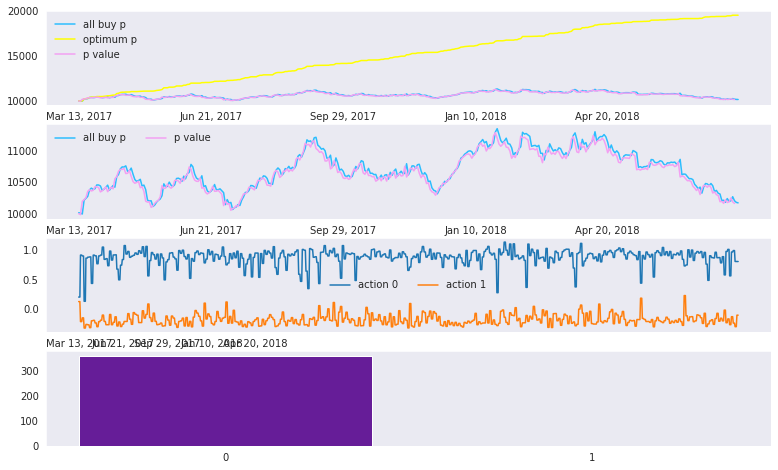

2020-09-23 02:44:08.794957
episode: 4979


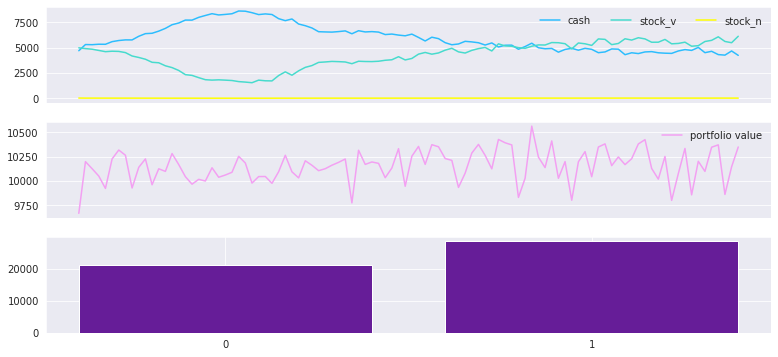

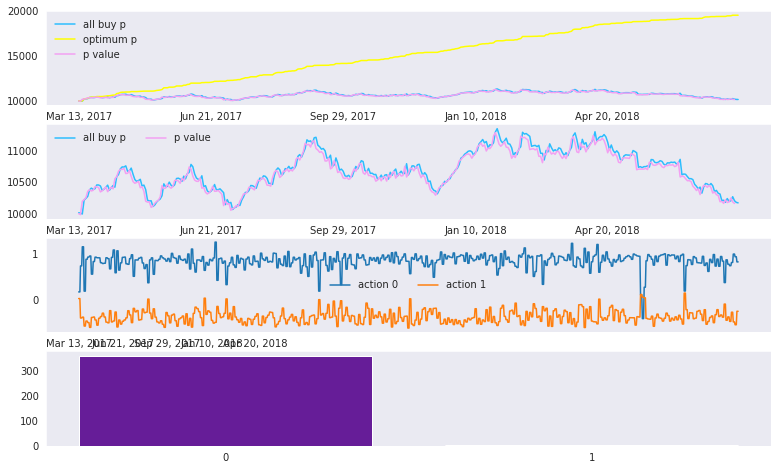

2020-09-23 03:04:32.113701
episode: 5145


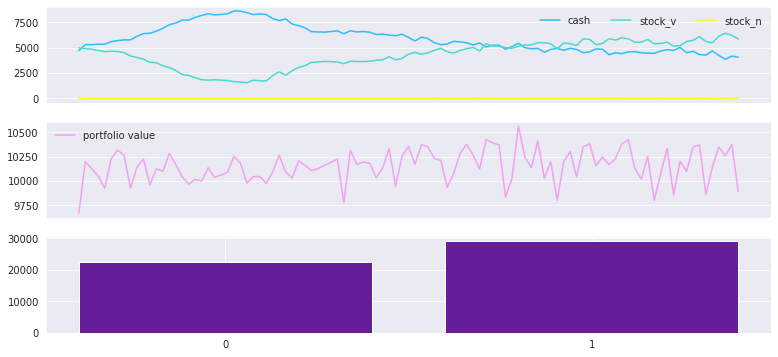

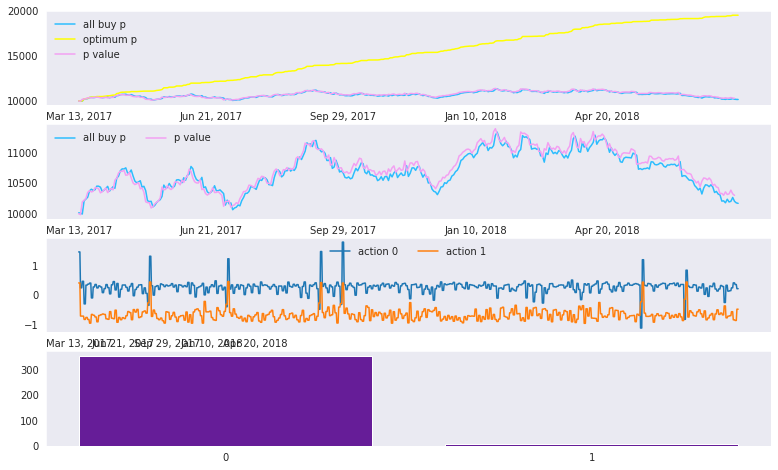

2020-09-23 03:25:19.770324
episode: 5311


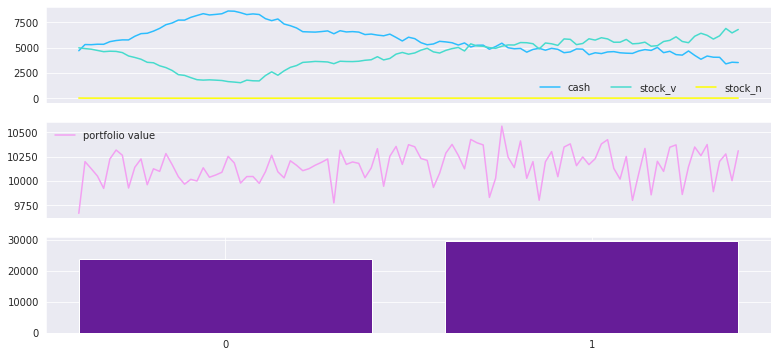

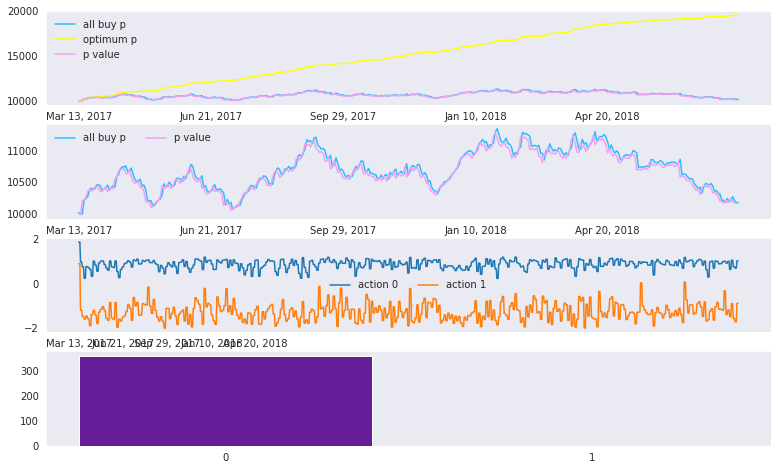

2020-09-23 03:45:50.543672
episode: 5477


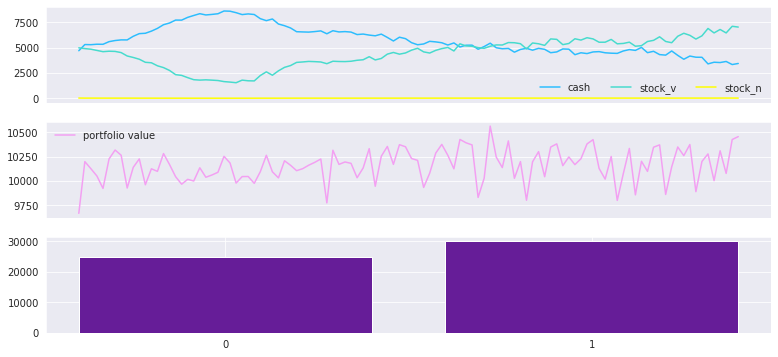

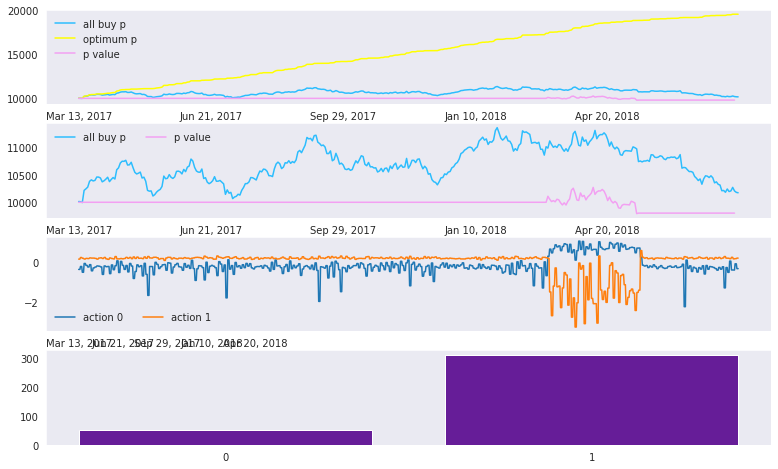

2020-09-23 04:06:21.404171
episode: 5643


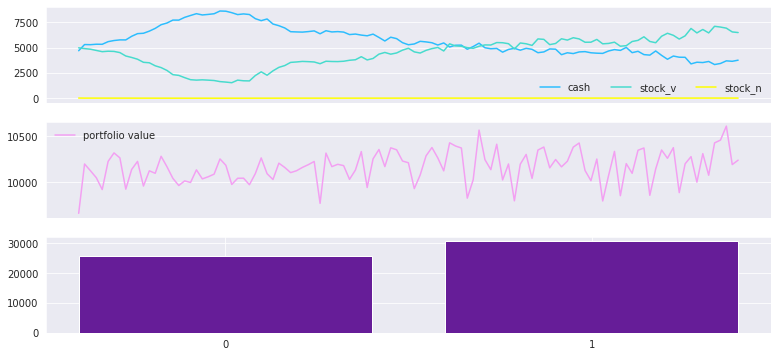

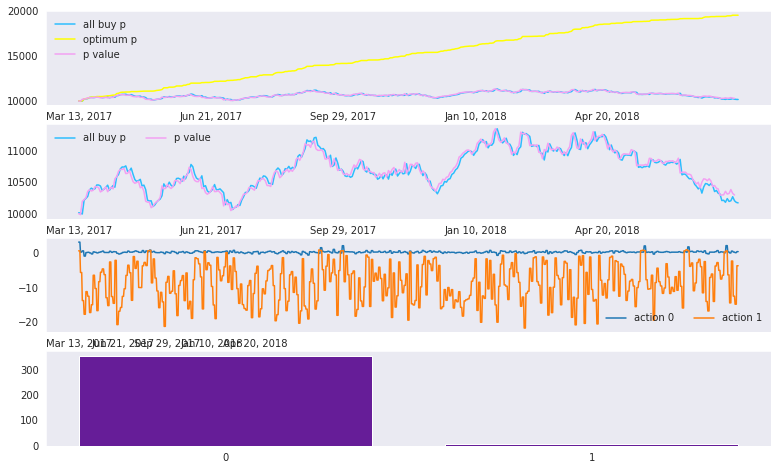

2020-09-23 04:27:22.152220
episode: 5809


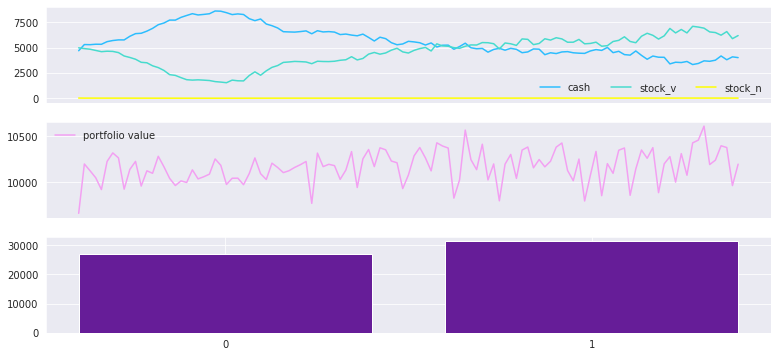

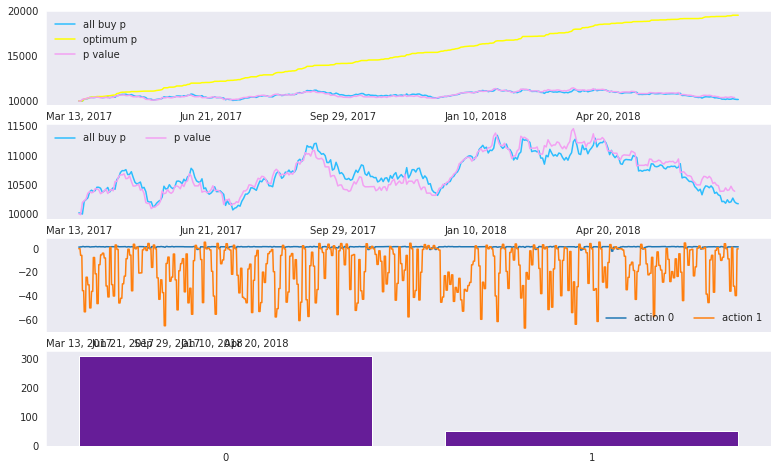

2020-09-23 04:48:00.277207
episode: 5975


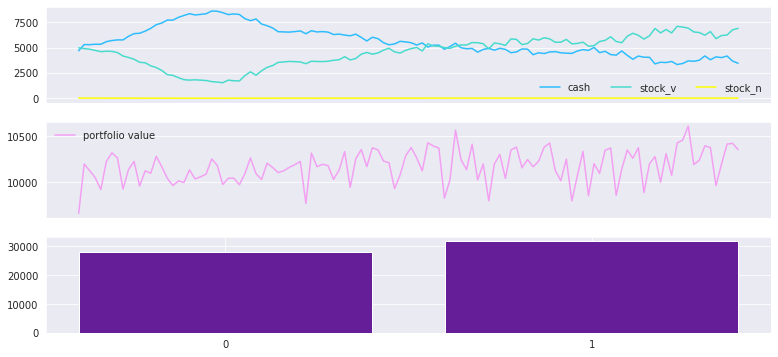

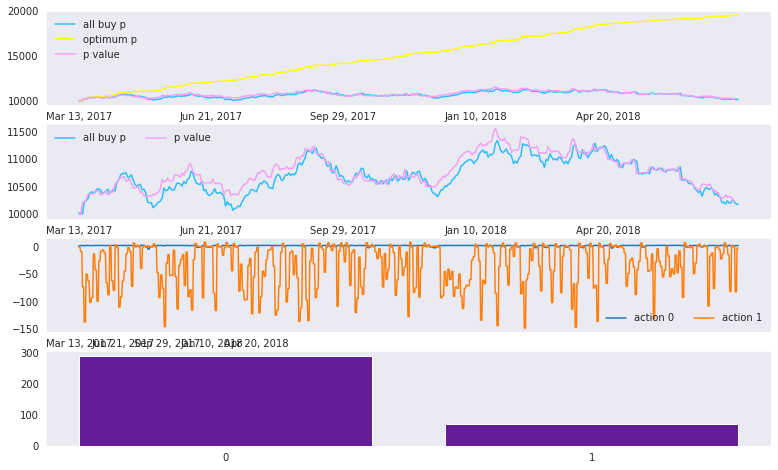

2020-09-23 05:08:36.990186
episode: 6141


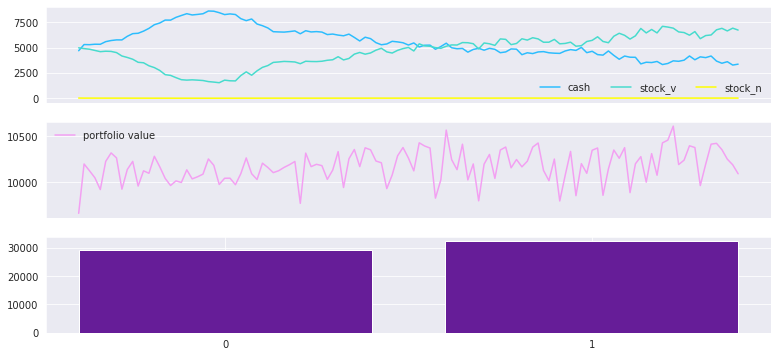

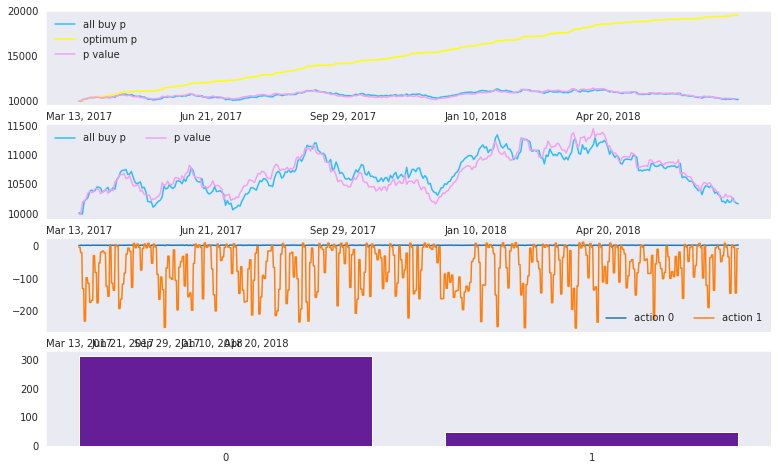

2020-09-23 05:29:48.208666
episode: 6307


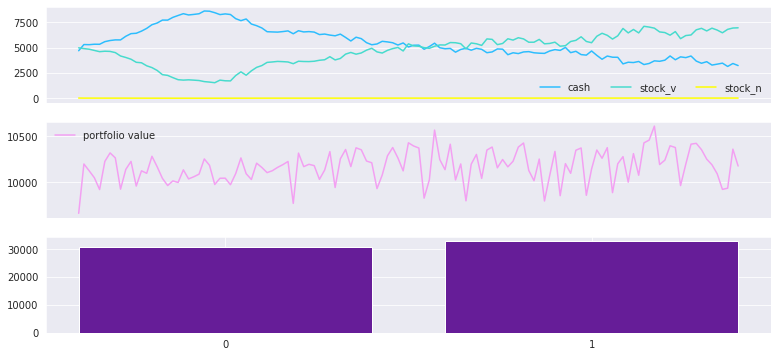

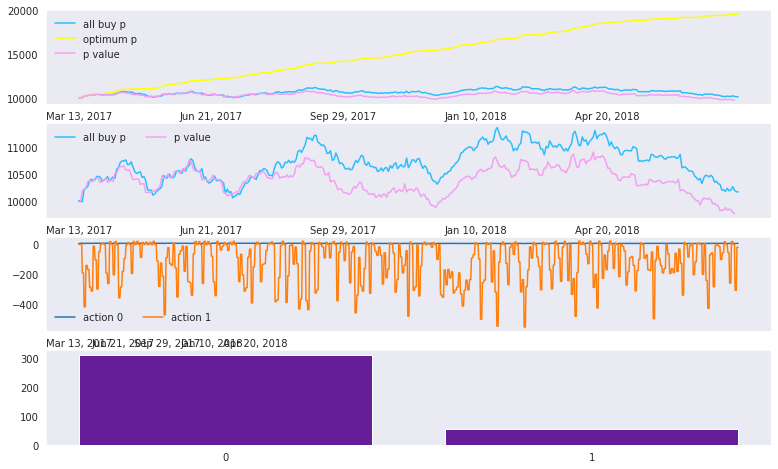

2020-09-23 05:50:30.208529
episode: 6473


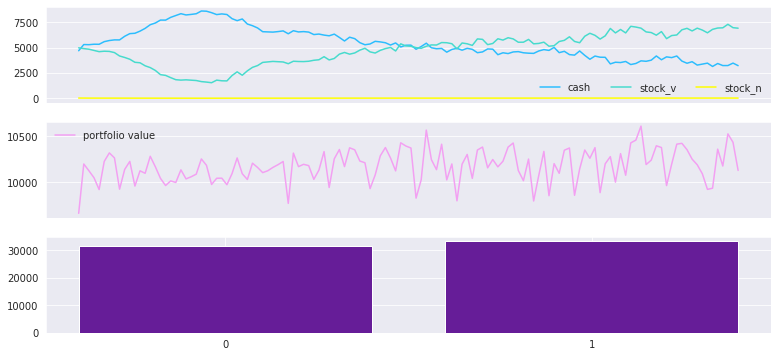

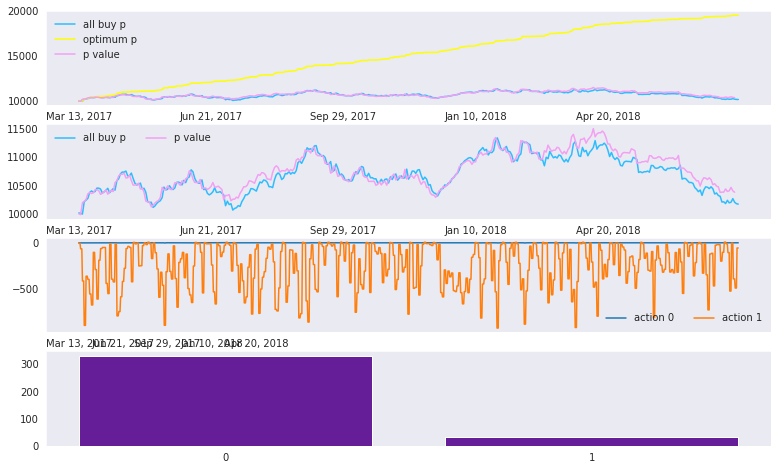

2020-09-23 06:11:17.274473
episode: 6639


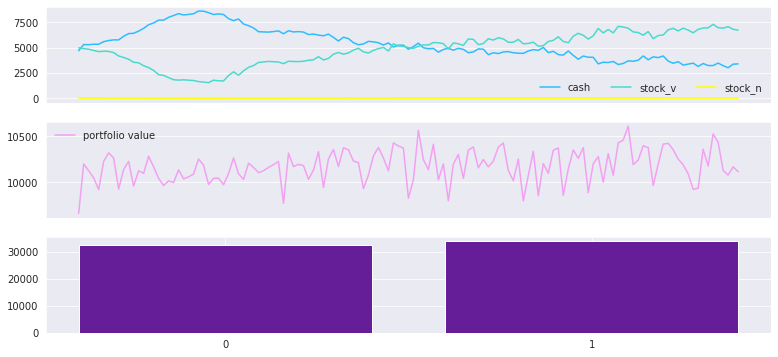

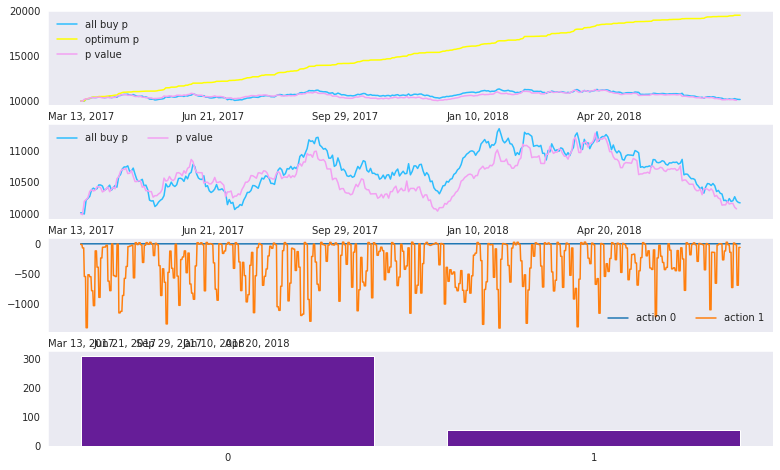

2020-09-23 06:32:35.701676
episode: 6805


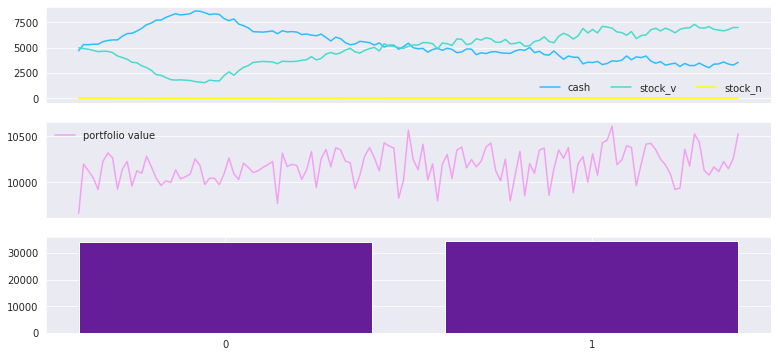

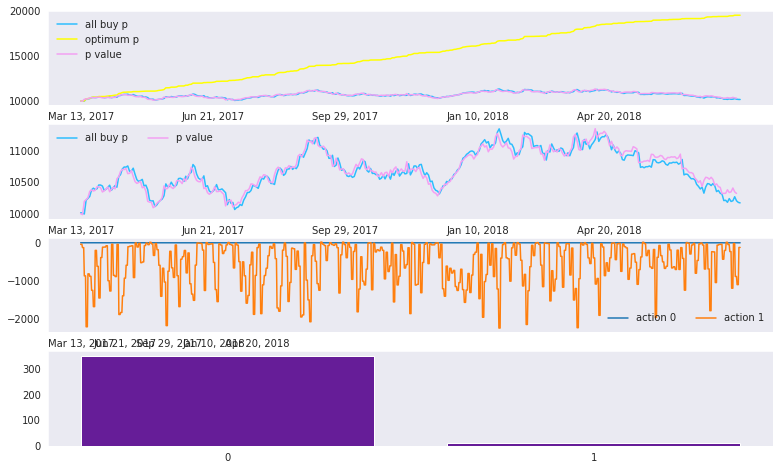

2020-09-23 06:53:35.568267
episode: 6971


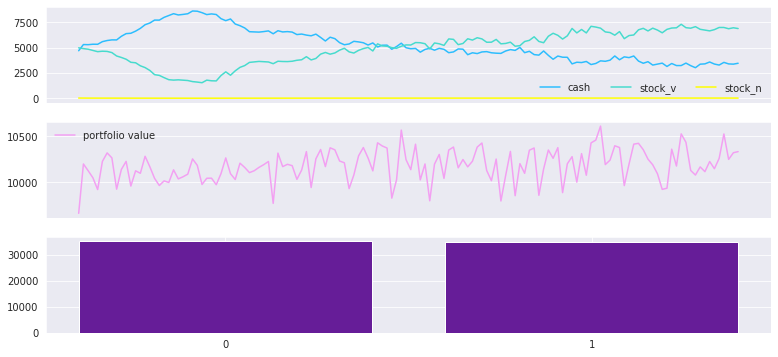

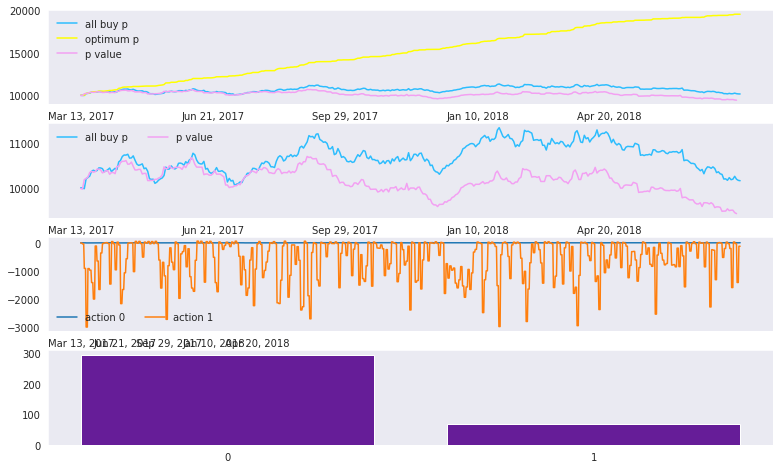

2020-09-23 07:14:26.715720
episode: 7137


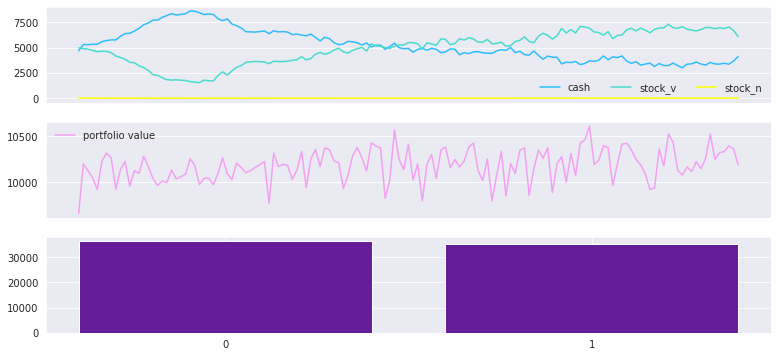

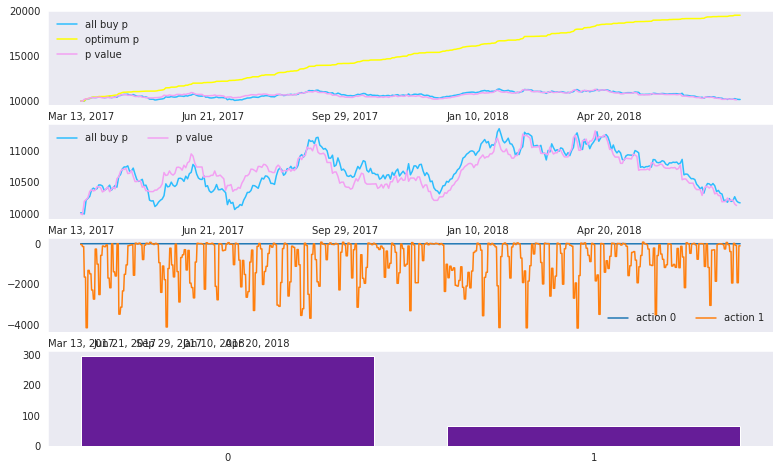

2020-09-23 07:35:56.961384
episode: 7303


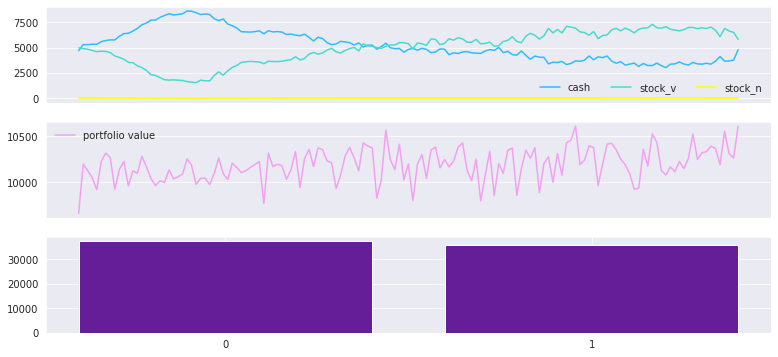

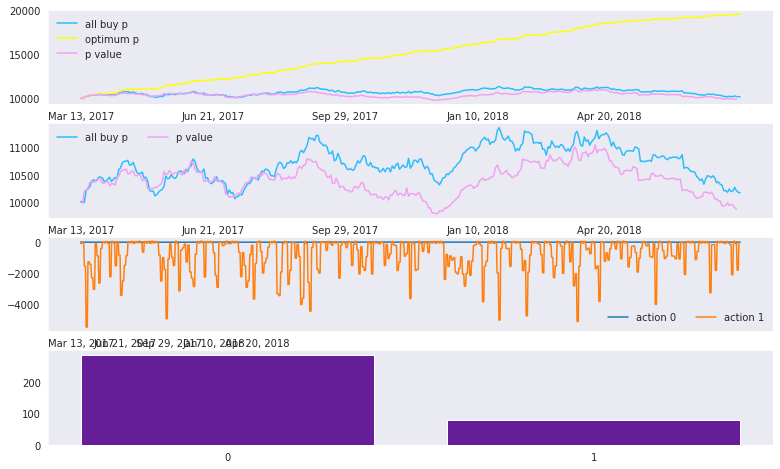

2020-09-23 07:56:55.870504
episode: 7469


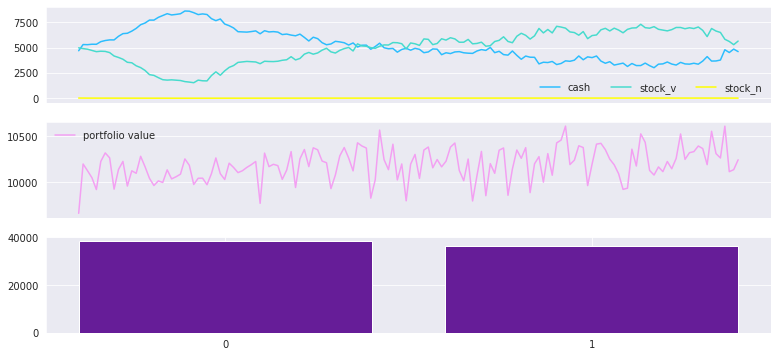

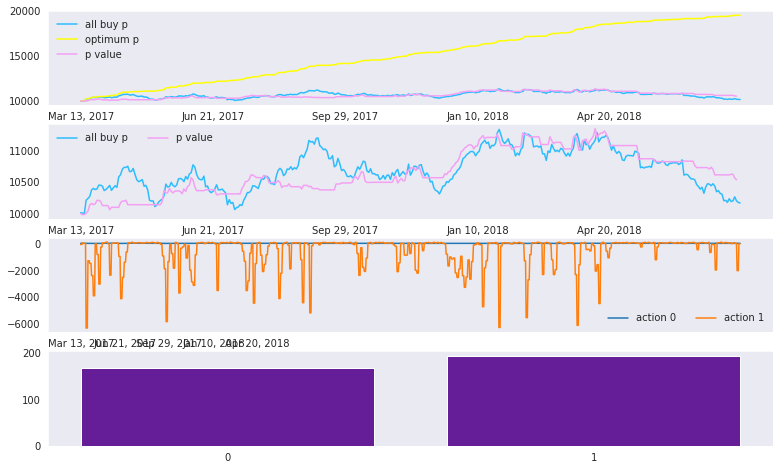

2020-09-23 08:17:59.552122
episode: 7635


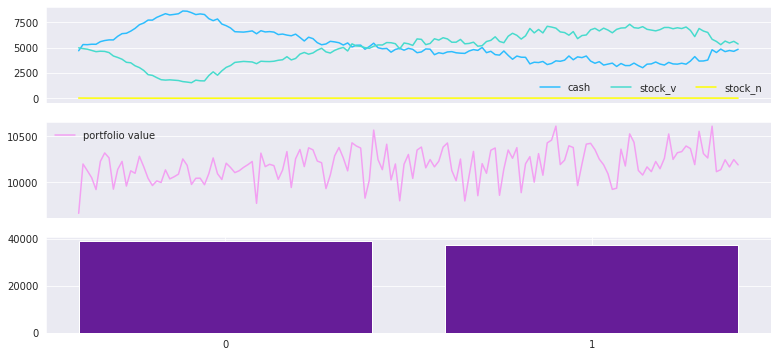

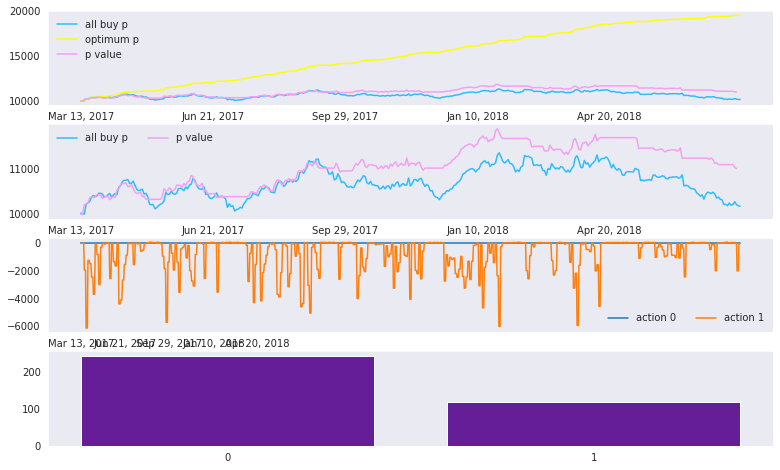

2020-09-23 08:39:39.153124
episode: 7801


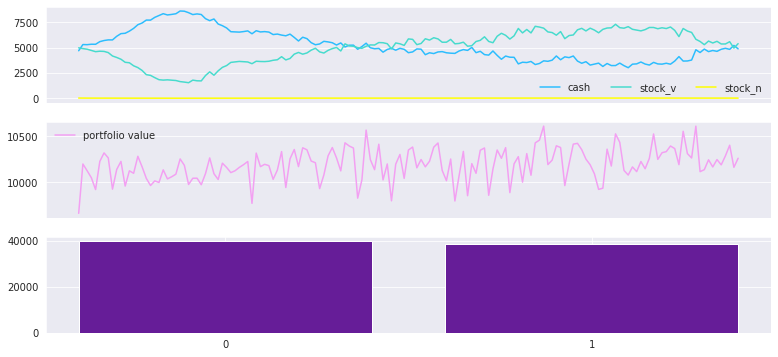

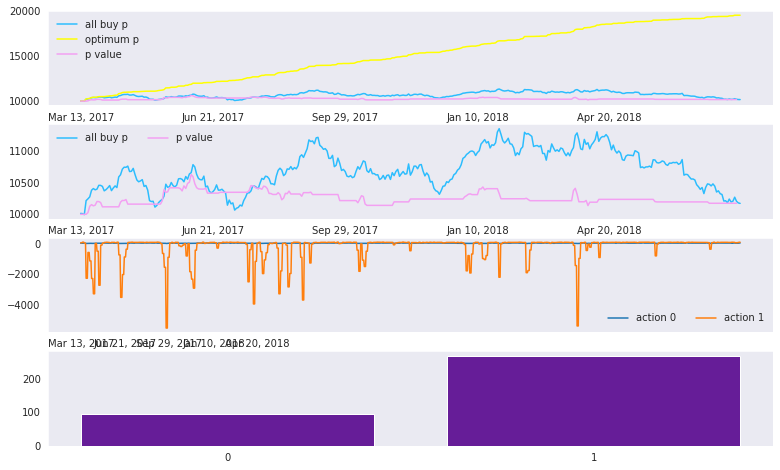

2020-09-23 09:00:44.838252
episode: 7967


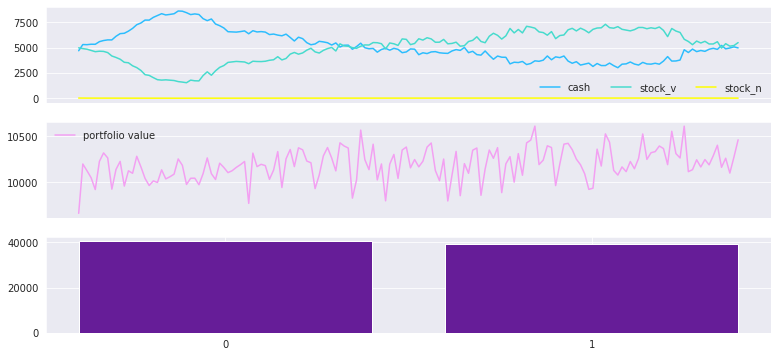

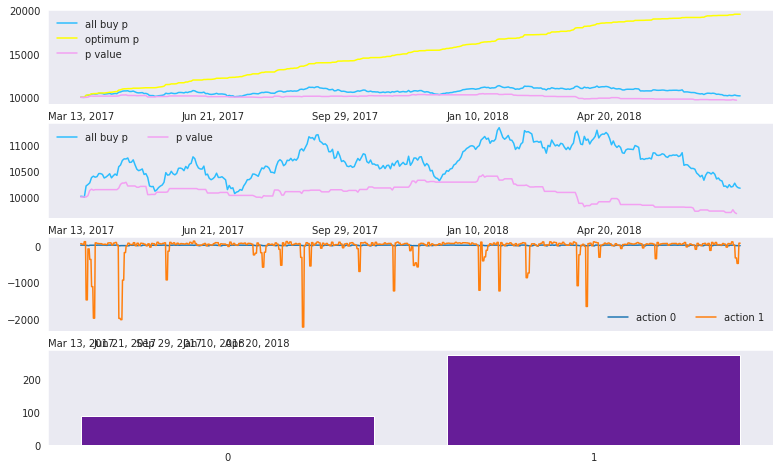

2020-09-23 09:21:55.369003
episode: 8133


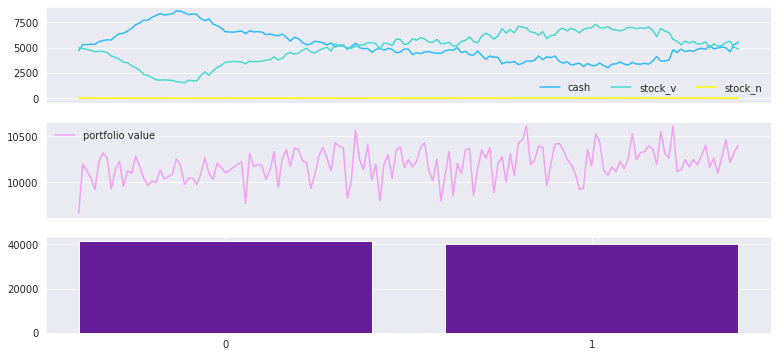

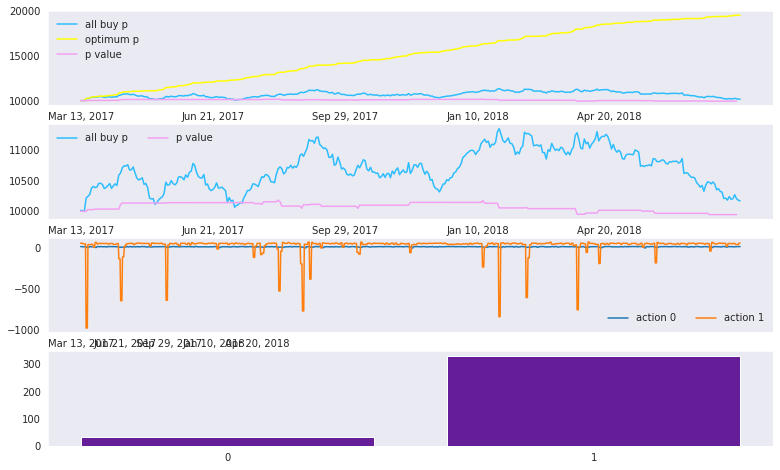

2020-09-23 09:43:10.165399
episode: 8299


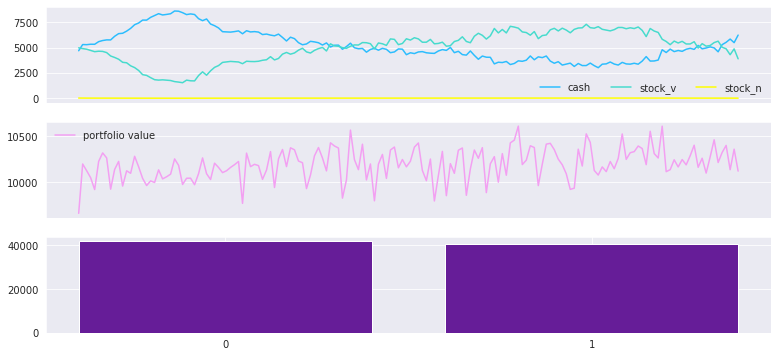

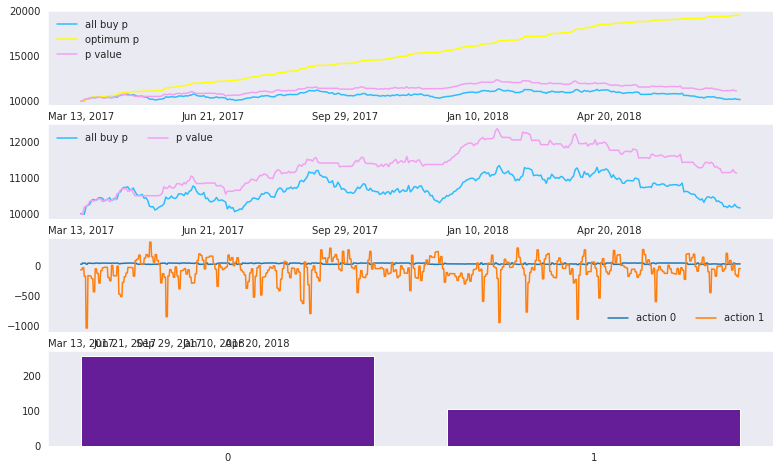

2020-09-23 10:05:06.271807
episode: 8465


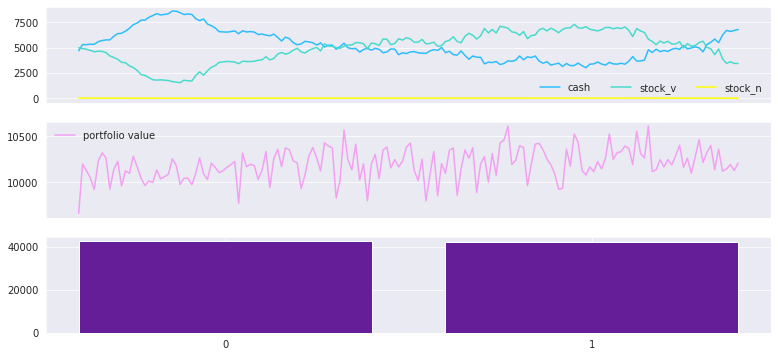

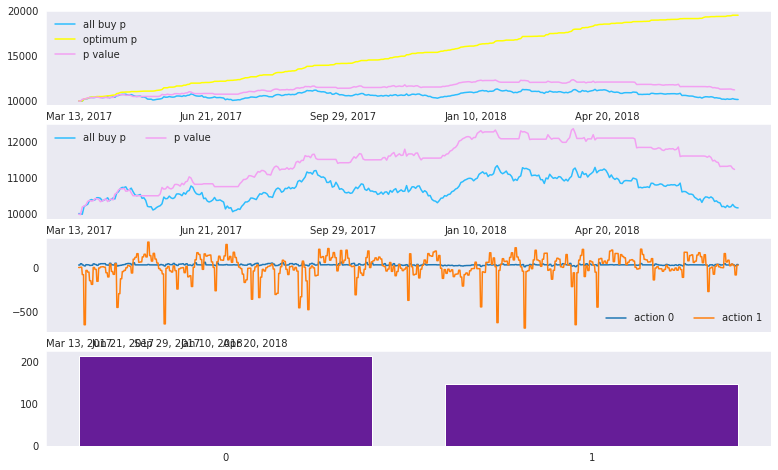

2020-09-23 10:26:27.991348
episode: 8631


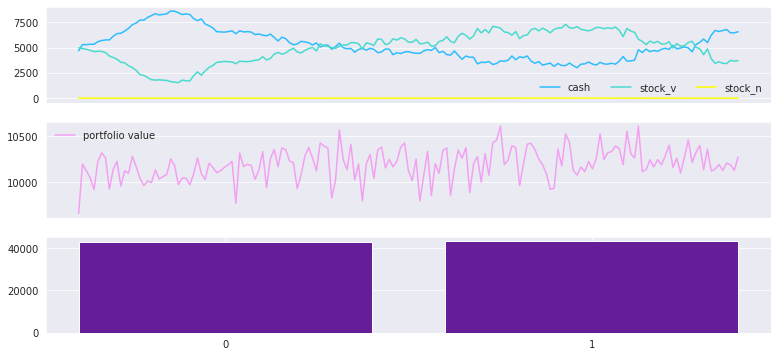

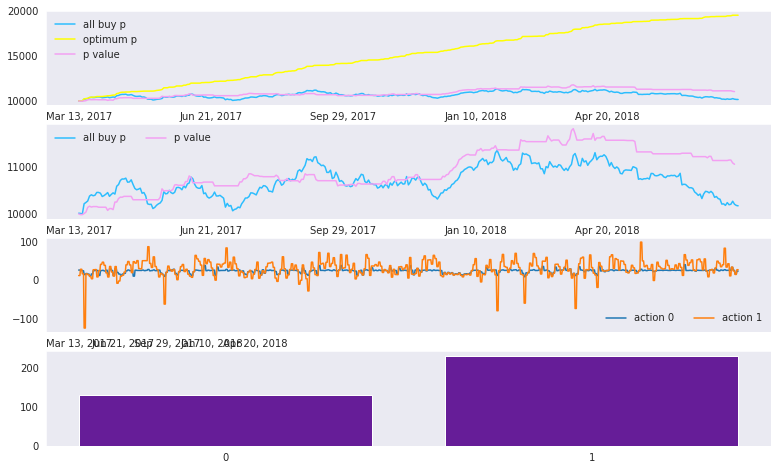

2020-09-23 10:47:55.523830
episode: 8797


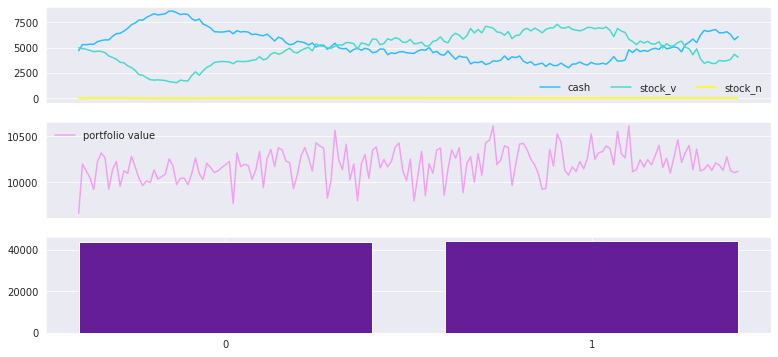

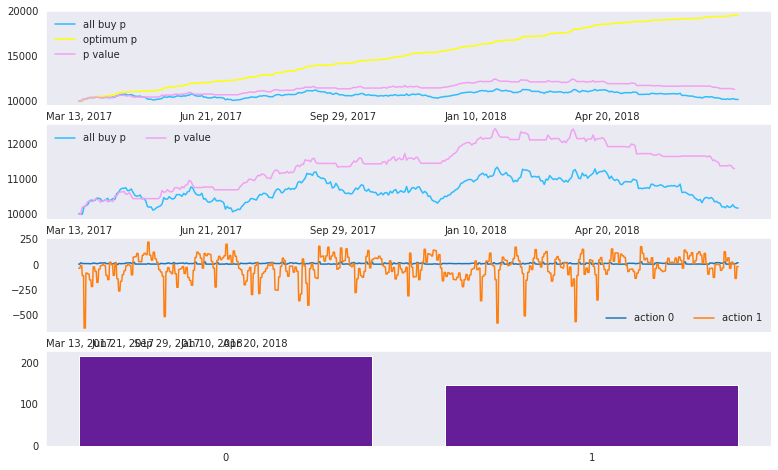

2020-09-23 11:10:10.724485
episode: 8963


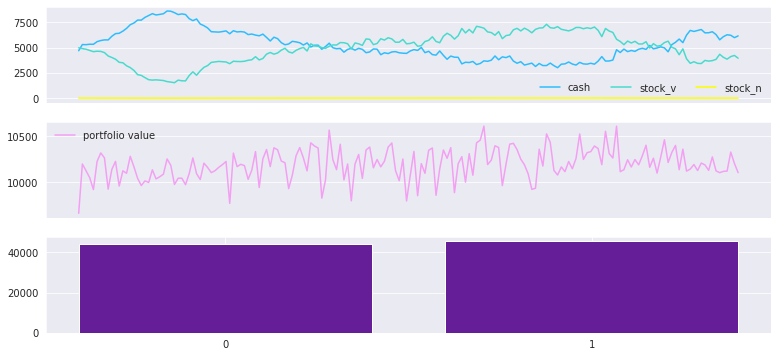

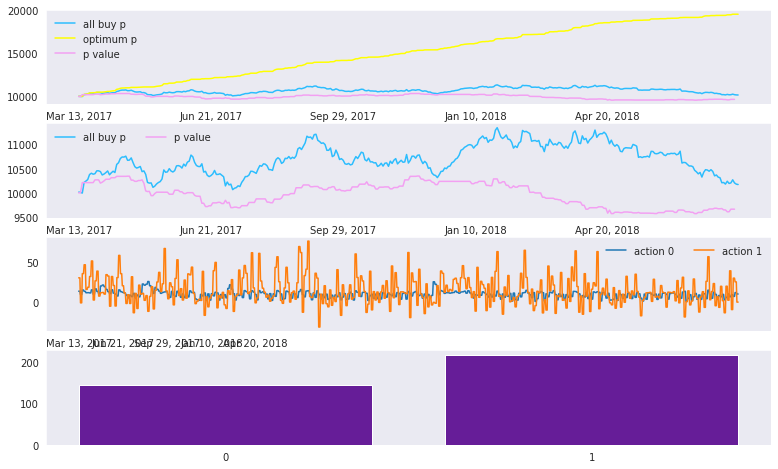

2020-09-23 11:31:47.317072
episode: 9129


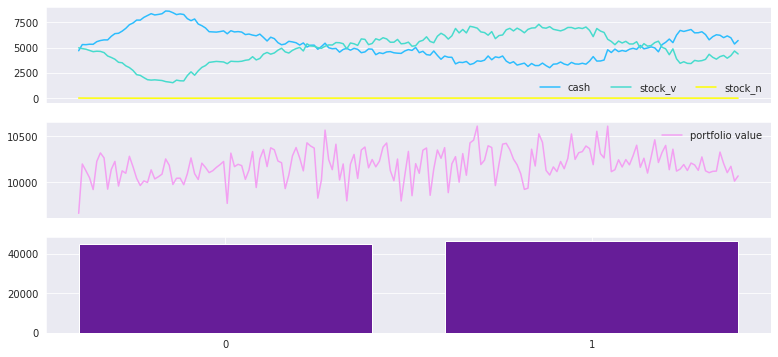

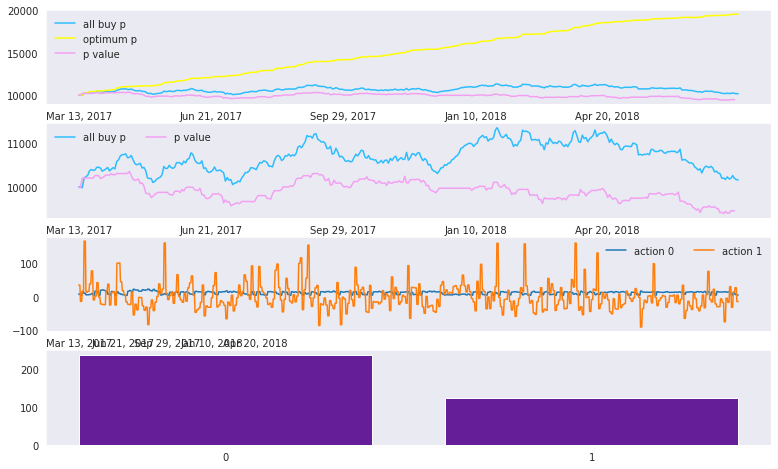

2020-09-23 11:53:22.281173
episode: 9295


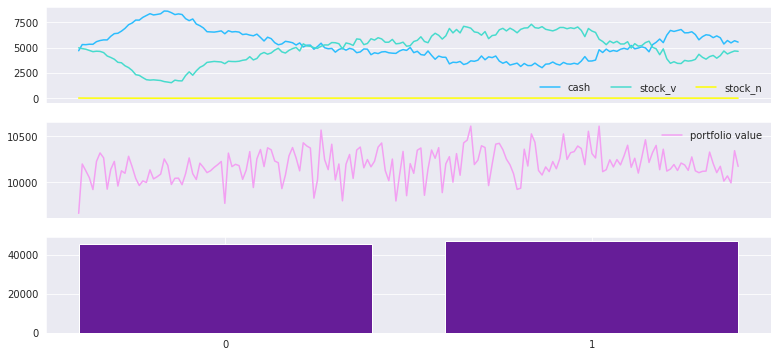

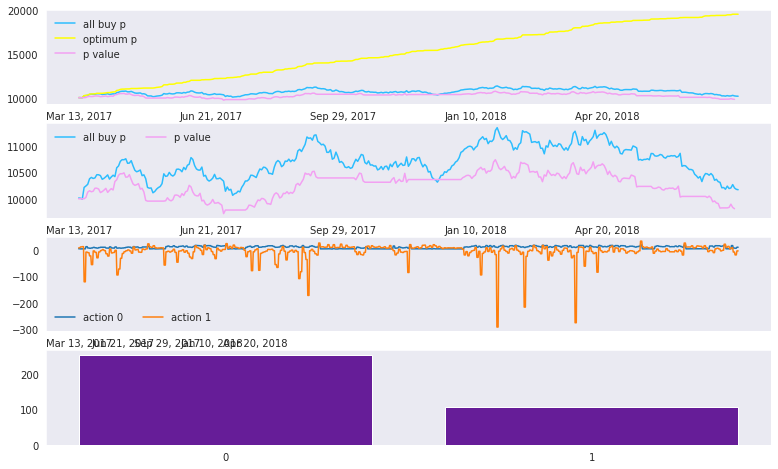

2020-09-23 12:15:57.565531
episode: 9461


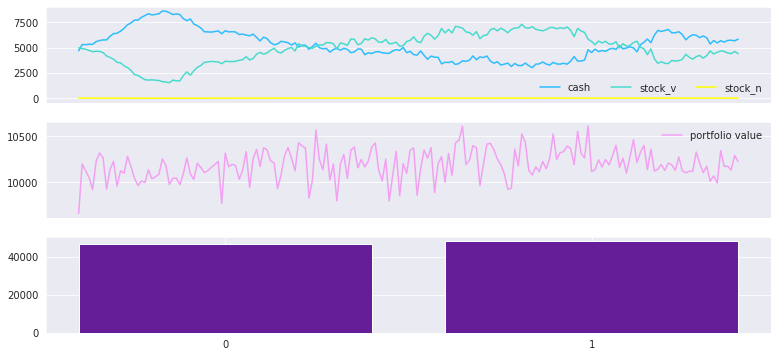

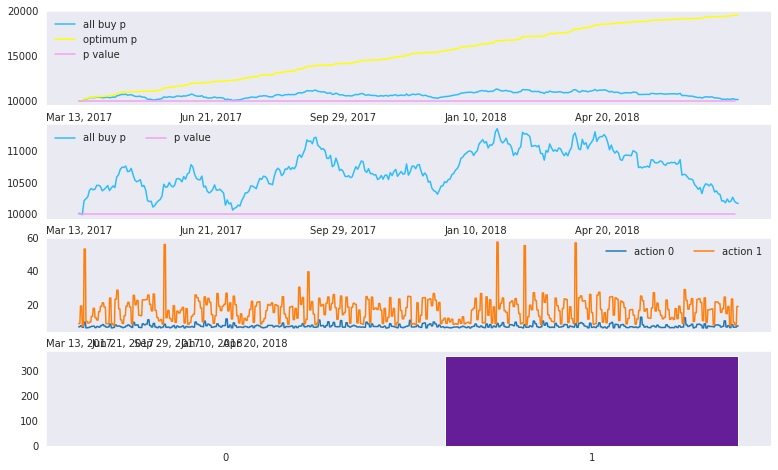

2020-09-23 12:38:04.613143
episode: 9627


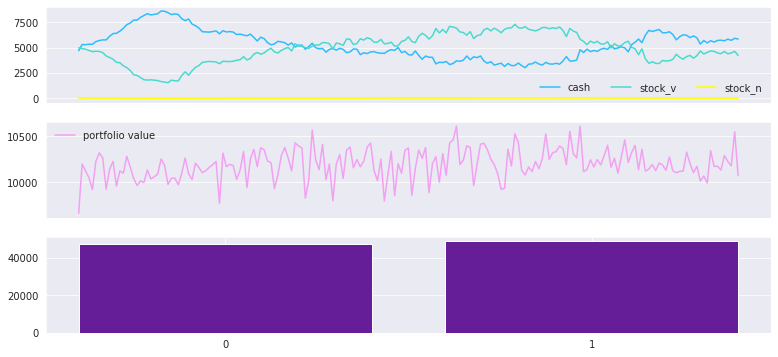

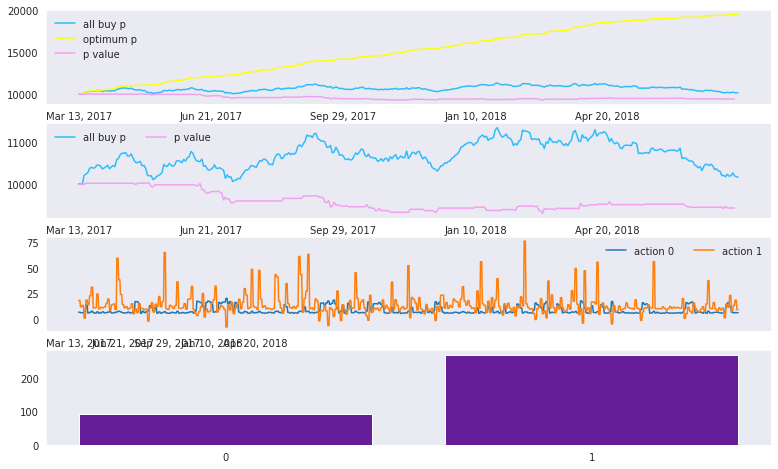

2020-09-23 12:59:27.462299
episode: 9793


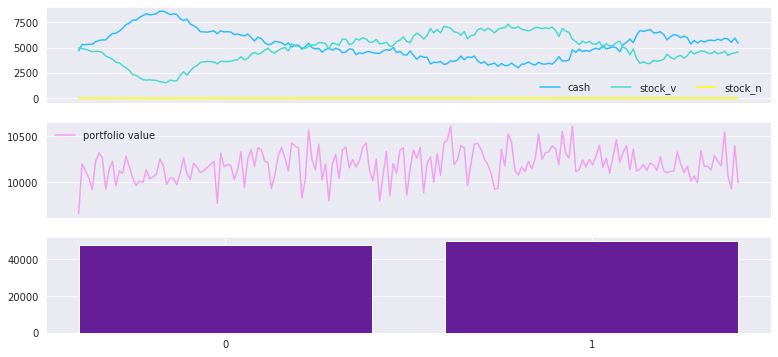

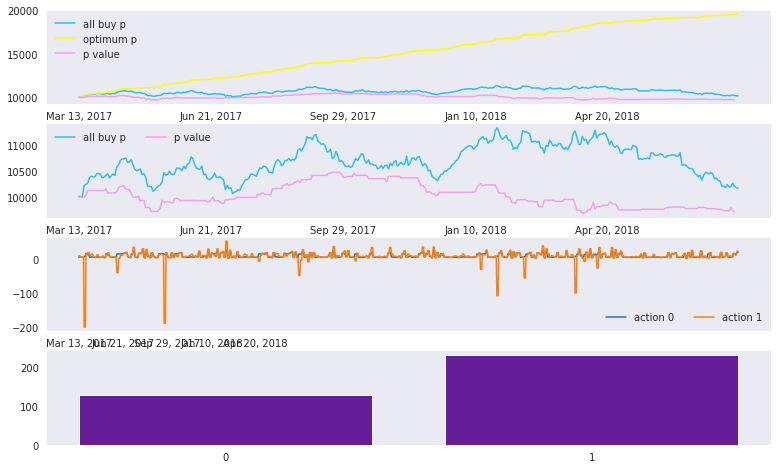

2020-09-23 13:22:28.019197
episode: 9959


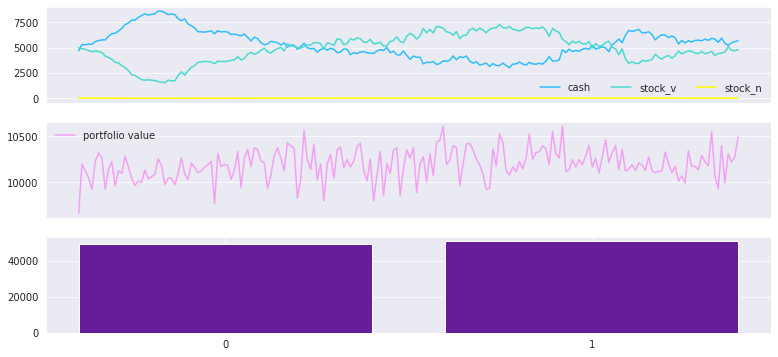

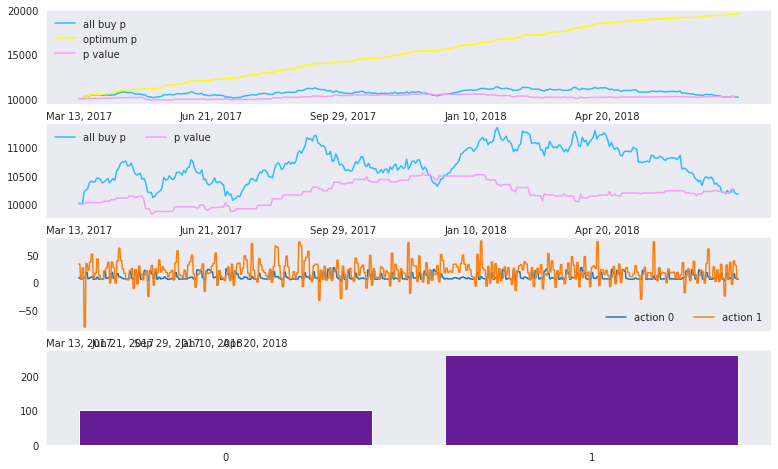

In [16]:
if __name__ == '__main__':
    rl = TDQN(
         episodes=10000,
         steps=500,
         batchsize=32,
         alpha=1e-4,
         decay_rate=0.999995,
         gamma=0.5,
         hidden=200, #################static
         init_cash=10000,
         print_rate=60,
         num_a=2,
         mem_siz=1000000,
         filename='9_a_',
         save=True, 
         load=False,
         get_output=True,
         w_updates=1000,
         inf=True,
         min_mem=0.01,
         log_freq=200,
         clip=10., #####no clip
         run=1 ################ remember to change run
    )
    rl.train()